In [179]:
from control import lqr
from common_function import newmark, eigenvalue, newmark_one
import numpy as np
from matplotlib import pyplot as plt
import os, re
import pandas as pd
from matplotlib import font_manager	 #matplotlib中 中文设置模块

In [180]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import platform
# 图像显示中文的问题，需要判断系统是windows还是苹果的
import matplotlib
import platform
sys_platform = platform.platform().lower()
if "windows" in sys_platform:
    font = {
    "family": "Times New Roman"
    }
    matplotlib.rc("font", **font)
else:
    font = {
    "family": "Arial Unicode MS"
    }
    matplotlib.rc("font", **font)
rc = {"mathtext.fontset" : "stix",}

plt.rcParams.update(rc)

In [181]:
wave = 0
dt = 0
name = "white_noise_190117_3.txt"
root = "./waves"
print(name)
wave_name = name.split('.')[0]
if name.endswith(".AT2"):
    filename = os.path.join(root, name)
    with open(filename, 'r') as fo:
        for i in range(3):
            fo.readline()
        line = fo.readline()
        target = re.search(r'DT= *(.*) *SEC', line, re.I | re.M)
        dt = float(target.group(1))
        wave = pd.read_table(filename, skiprows=4, sep="  ", header=None, engine='python')
        wave = wave.fillna(0)
        wave = wave.values
        size = wave.size
        wave = wave.reshape((size,))
if name.endswith(".txt"):
    filename = os.path.join(root, name)
    wave = np.loadtxt(filename)
    dt = 0.02
wave = wave / max(abs(wave)) * 0.3 * 9.8
wave_len = len(wave)
time = np.arange(0, wave_len * dt, dt)

white_noise_190117_3.txt


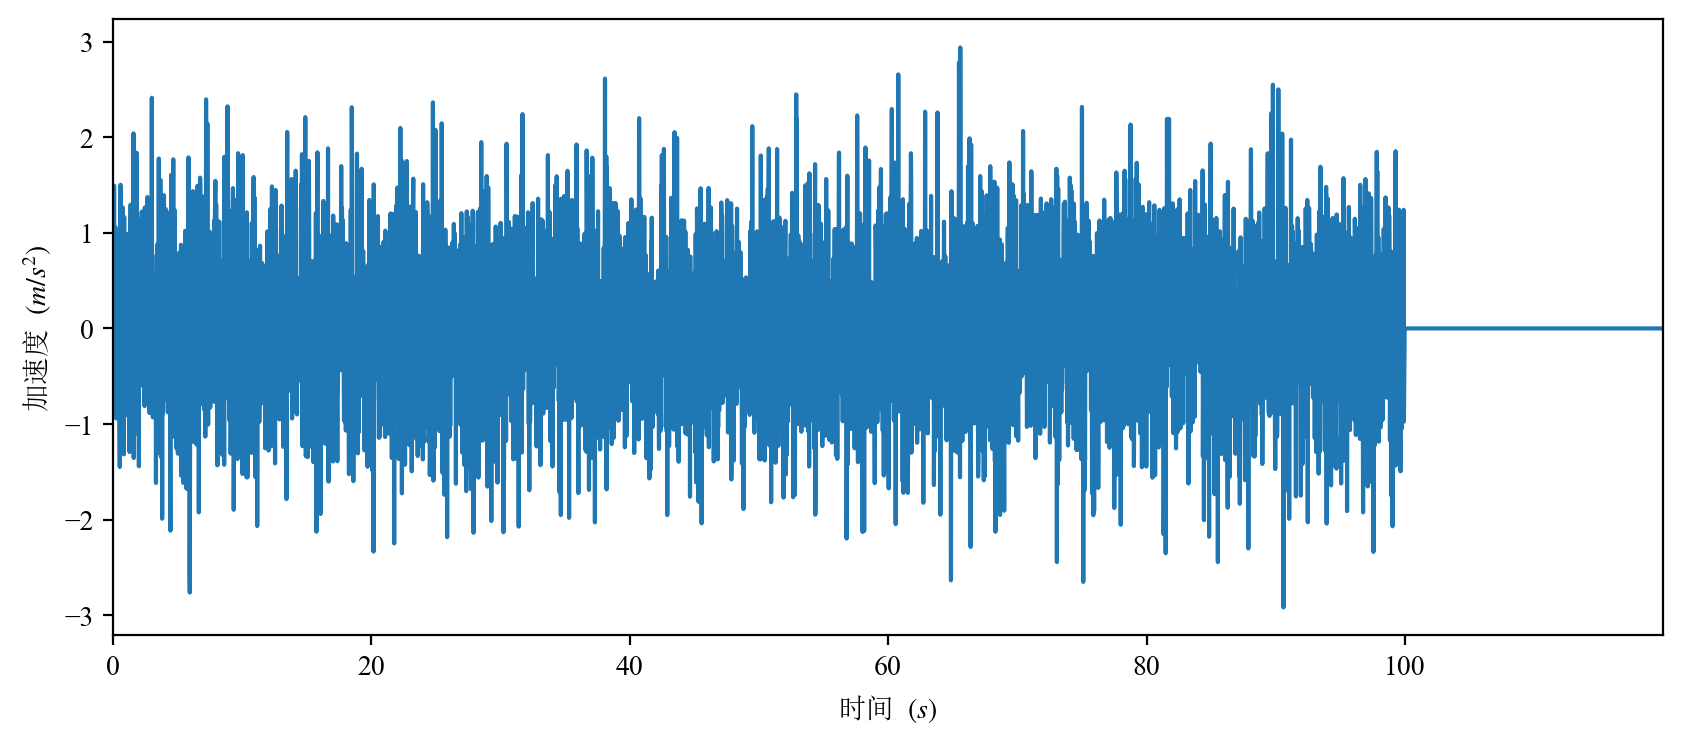

In [182]:
# # 生成随机白噪声
# num = 16000
# wave = np.zeros(num)
# for i in range(13000):
#     wave[i] = np.random.randn()
# dt = 0.02
# wave = wave / max(abs(wave)) * 0.3 * 9.8
# wave_len = len(wave)
# time = np.arange(0, wave_len * dt, dt)
plt.figure(figsize=(10,4))
plt.xlim([0, max(time)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s^2)$',fontname = 'SimSun',fontsize = 10)
pic_name = r"人工波加速度时程"
plt.plot(time, wave)
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [183]:
# 加速度插值
dt_s = dt / 2
t_s = np.arange(0, max(time) + 10, dt_s)
wave_s = np.interp(t_s, time, wave)
wave_len_s = len(wave_s)
wave_len_s

12999

In [184]:
m = 20  # 单位：kg
k = 2700  # 单位：N/m
M = np.array([[m]])
K = np.array([[k]])
zeta = 0.02  # 结构固有阻尼比

w, T, phi, gamma, M_par = eigenvalue(M, K)
w0 = w[0]

In [185]:
T[0]

0.5407704901298149

In [186]:
c = 2 * zeta * m * w0

In [187]:
mu = 1
ksi = 0.001
kpa = 10
md0 = mu * m
cd0 = 2 * ksi * m * w0
kd0 = kpa * k

In [188]:
# 半主动惯容基本参数
min_max = mu * m
min_min = 0
cd_max = cd0
cd_min = cd0
kd = kpa * k

In [189]:
# 状态空间矩阵
A = np.array([[0, 1], [-w0 ** 2, -2 * zeta * w0]], dtype=float)
B = np.array([[0, 0], [0, -1 / m]], dtype=float)

In [190]:
# 原结构
M0 = np.array(m, ndmin=2, dtype=float)
C0 = np.array(c, ndmin=2, dtype=float)
K0 = np.array(k, ndmin=2, dtype=float)
E0 = np.array(1, ndmin=2, dtype=float)
y0, dy0, ddy0, ddy0_ab = newmark(K0, M0, C0, wave_s, dt_s, E0)

In [191]:
# 被动控制结构
M = np.array([[m, 0], [0, md0]], ndmin=2, dtype=float)
K = np.array([[k + kd0, -kd0], [-kd0, kd0]], ndmin=2, dtype=float)
C = np.array([[c, 0], [0, cd0]], ndmin=2, dtype=float)
E = np.array([[1], [0]], ndmin=2, dtype=float)
u1, du1, _, ddu1_ab = newmark(K, M, C, wave_s, dt_s, E)

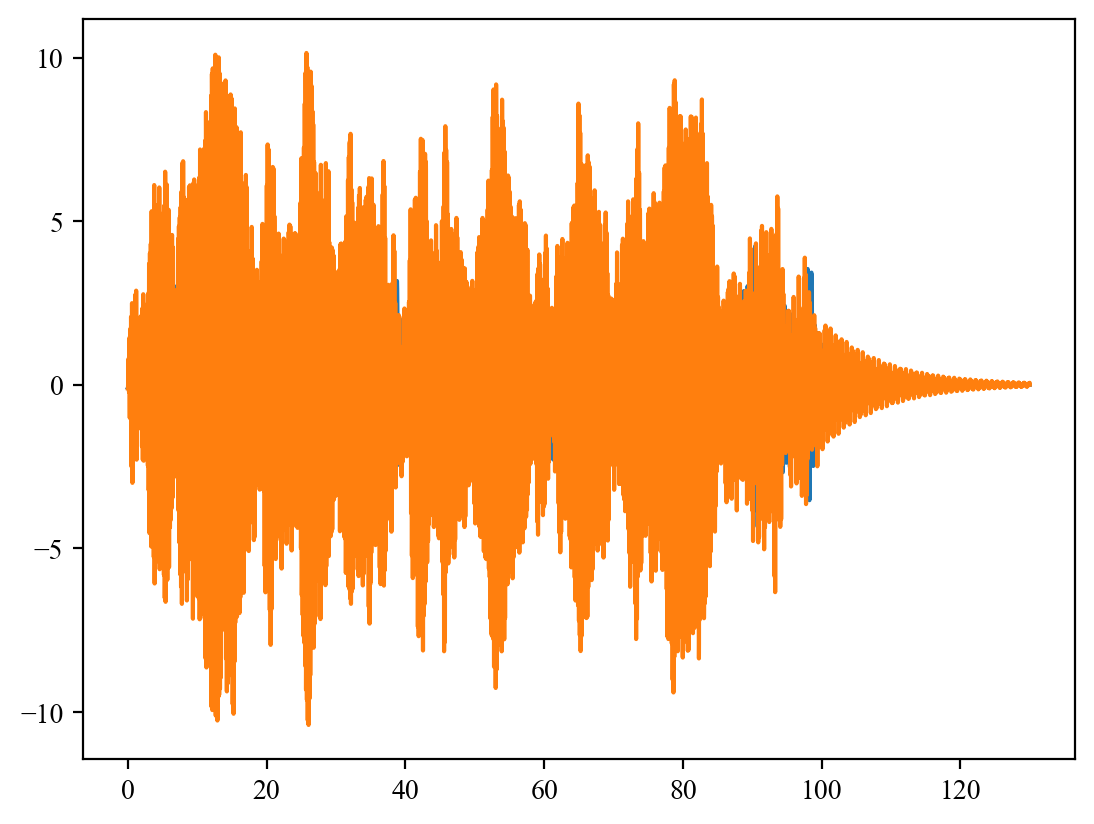

In [192]:
plt.plot(t_s, ddy0_ab.reshape(-1))
plt.plot(t_s, ddu1_ab[0, :])

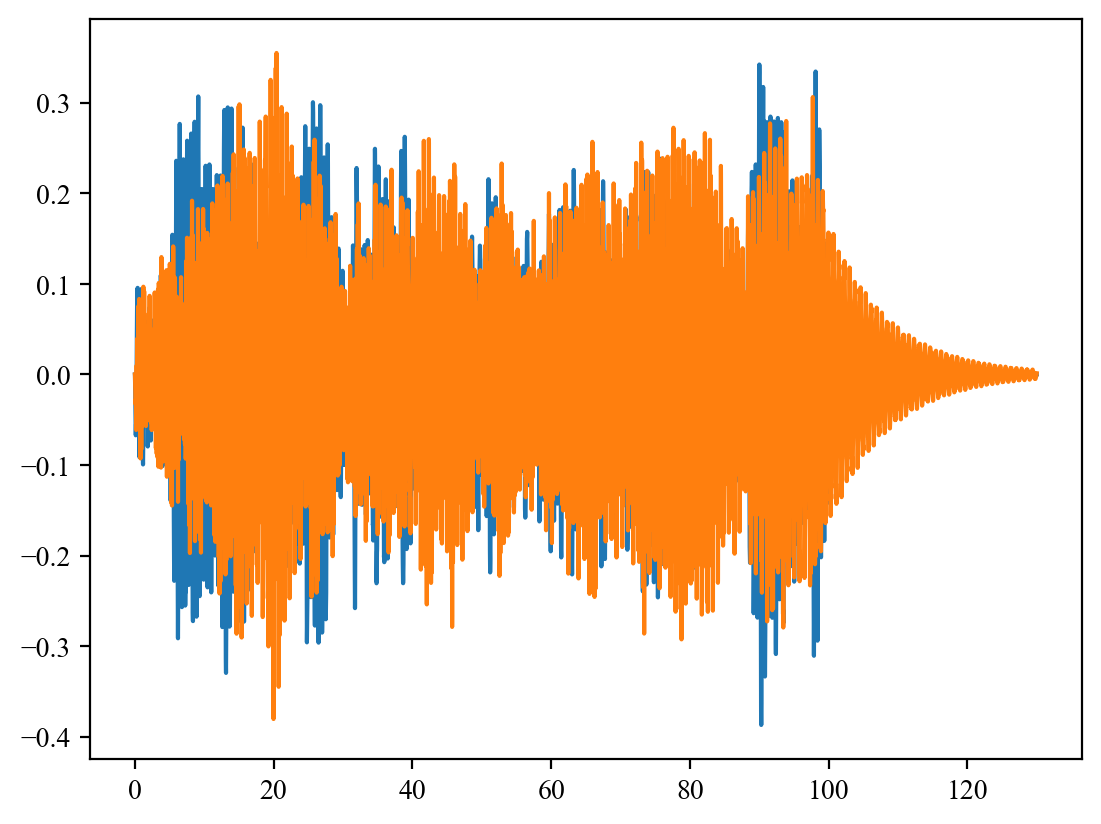

In [193]:
plt.plot(t_s, dy0.reshape(-1))
plt.plot(t_s, du1[0, :])

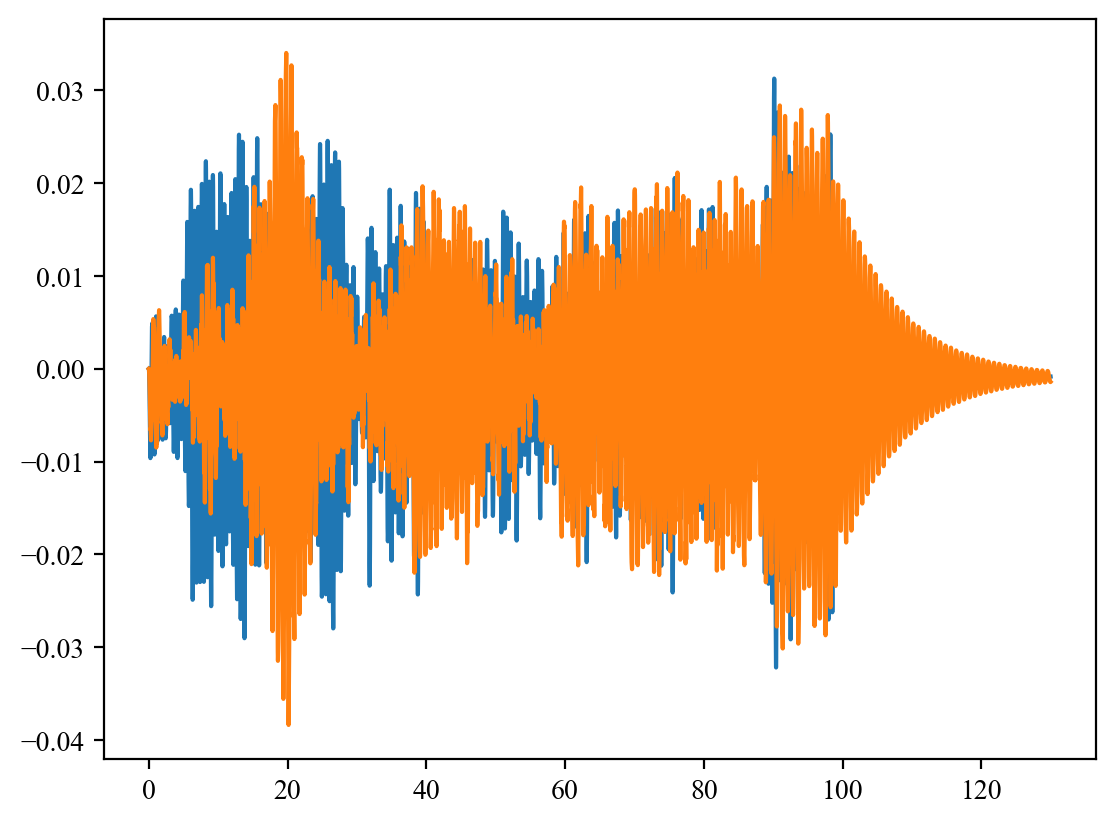

In [194]:
plt.plot(t_s, y0.reshape(-1))
plt.plot(t_s, u1[0, :])

In [195]:
# 反馈增益矩阵
Q = np.diag([1, 0])
R = np.diag([1e-5, 1e-5])
D, _, _ = lqr(A, B, Q, R)
D = -D

In [196]:
# 半主动控制结构
u2 = np.zeros([2, wave_len_s])
du2 = np.zeros([2, wave_len_s])
du2[1, 0] = -wave_s[0]
F = np.zeros([2, wave_len_s])
ft = np.zeros(wave_len_s)
ud = np.zeros(wave_len_s)
dud = np.zeros(wave_len_s)
ddud = np.zeros(wave_len_s)
fmax = np.zeros(wave_len_s)
fmin = np.zeros(wave_len_s)
fa = np.zeros(wave_len_s)

y2 = np.zeros(wave_len_s)
dy2 = np.zeros(wave_len_s)
ddy2 = np.zeros(wave_len_s)
ddy2_ab = np.zeros(wave_len_s)
ag_pre = 0

for i in range(wave_len_s - 1):
    # p = np.array([[0], [-wave_s[i]]])  # 当前荷载向量
    F[:, i, None] = np.dot(D, u2[:, i, None])  # 当前反馈力
    ft[i] = F[1, i]  # 当前目标出力
    ud[i] = u2[0, i] - ft[i] / kd  # 当前惯容位移
    dud[i] = (ud[i] - ud[i - 1]) / dt_s  # 当前惯容速度
    ddud[i] = (dud[i] - dud[i - 1]) / dt_s  # 当前惯容加速度

    # 当前出力上限
    fmax[i] = max(
        [min_max * ddud[i] + cd0 * dud[i],
         min_min * ddud[i] + cd0 * dud[i]])
    # 当前出力下限
    fmin[i] = min([min_max * ddud[i] + cd0 * dud[i],
                   min_min * ddud[i] + cd0 * dud[i]])
    while True:
        if ft[i] < fmin[i]:
            ft[i] = fmin[i]
        elif ft[i] > fmax[i]:
            ft[i] = fmax[i]
        else:
            fa[i] = ft[i]
            break
        ud[i] = u2[0, i] - ft[i] / kd
        dud[i] = (ud[i] - ud[i - 1]) / dt_s  # 当前惯容速度
        ddud[i] = (dud[i] - dud[i - 1]) / dt_s  # 当前惯容加速度
        # 当前出力上限
        fmax[i] = max(
            [min_max * ddud[i] + cd0 * dud[i],
             min_min * ddud[i] + cd0 * dud[i]])
        # 当前出力下限
        fmin[i] = min([min_max * ddud[i] + cd0 * dud[i],
                       min_min * ddud[i] + cd0 * dud[i]])
    # Newmark_beta法
    ag = wave_s[i] + fa[i] / m
    z_acc = ag - ag_pre
    z_y = (-m * z_acc + (4 / dt) * m * dy2[i] + 2 * m * ddy2[i] + 2 * c * dy2[i]) / (k + 2 * c / dt + m * 4 / (dt ** 2))
    y2[i + 1] = y2[i] + z_y
    z_dy = 2 / dt * z_y - 2 * dy2[i]
    dy2[i + 1] = dy2[i] + z_dy
    z_ddy = 4 / (dt ** 2) * z_y - (4 / dt) * dy2[i] - 2 * ddy2[i]
    ddy2[i + 1] = ddy2[i] + z_ddy
    ddy2_ab[i] = ddy2[i] + ag

    ag_pre = ag
    u2[0, i + 1] = y2[i + 1]
    u2[1, i + 1] = dy2[i + 1]
    du2[0, i + 1] = dy2[i + 1]
    du2[1, i] = ddy2_ab[i]

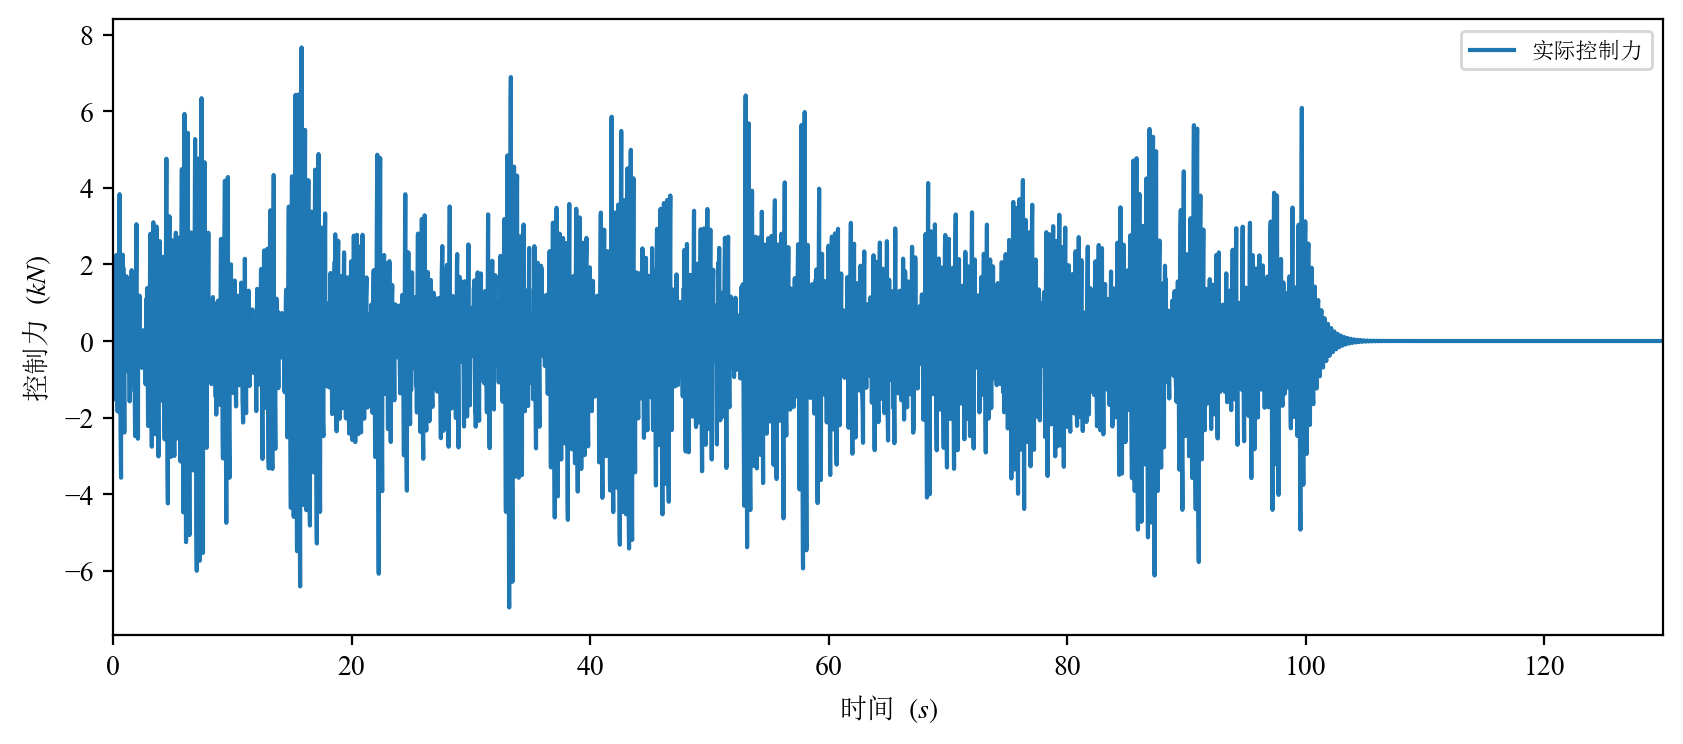

In [197]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.plot(t_s, fmax, label="出力上限")
# plt.plot(t_s, fmin, label="出力下限")
plt.plot(t_s, fa, label="实际控制力")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'控制力 $(kN)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"控制力限值"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [198]:
# plt.figure(figsize=(4,4))
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.plot(u1[1, :], du1[1, :] * cd0, label="被动控制系统")
# plt.plot(ud, dud * cd0, label="可变惯容半主动控制系统")
# plt.xlabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
# plt.ylabel(r'阻尼力 $(kN)$',fontname = 'SimSun',fontsize = 10)
# # legend中文显示问题
# # font = font_manager.FontProperties(fname = 'C:/Windows/fonts/simsun.ttc')
# font = {
#     "family": "SimSun",
#     'weight':'normal',
#     "size": 8
#     }
# plt.legend(prop = font, loc='best')
# pic_name = r"滞回曲线对比"
# plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
# plt.show()
# plt.close()

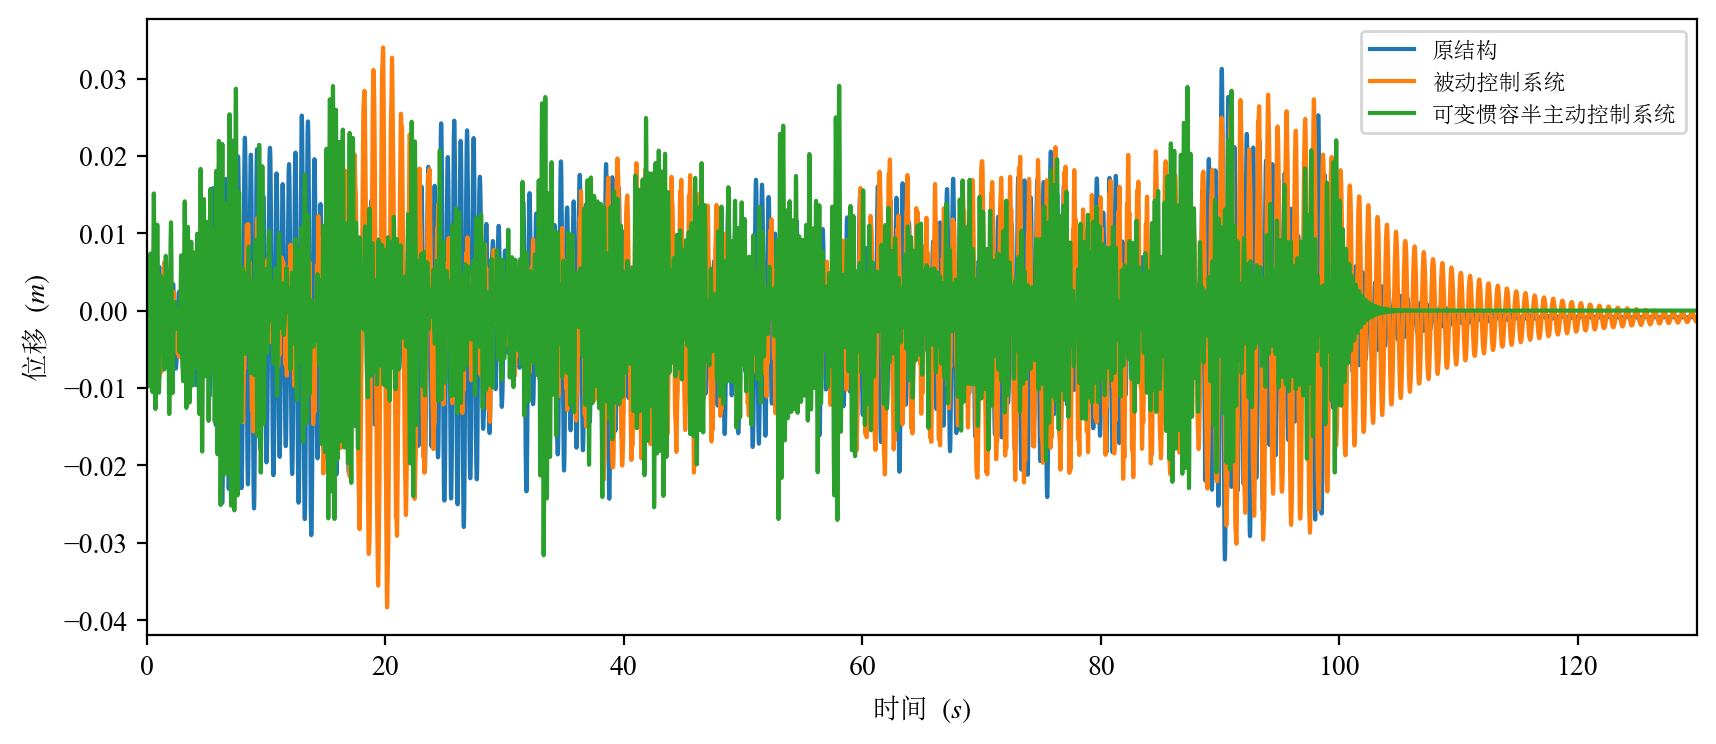

被动控制位移减震比：1.1922820241720877
半主动控制位移减震比：0.9828209628415592


In [199]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, y0.reshape(-1), label="原结构")
plt.plot(t_s, u1[0, :], label="被动控制系统")
plt.plot(t_s, y2, label="可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"位移对比"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制位移减震比：{}".format(max(abs(u1[0, :])) / max(abs(y0.reshape(-1)))))
print("半主动控制位移减震比：{}".format(max(abs(y2)) / max(abs(y0.reshape(-1)))))

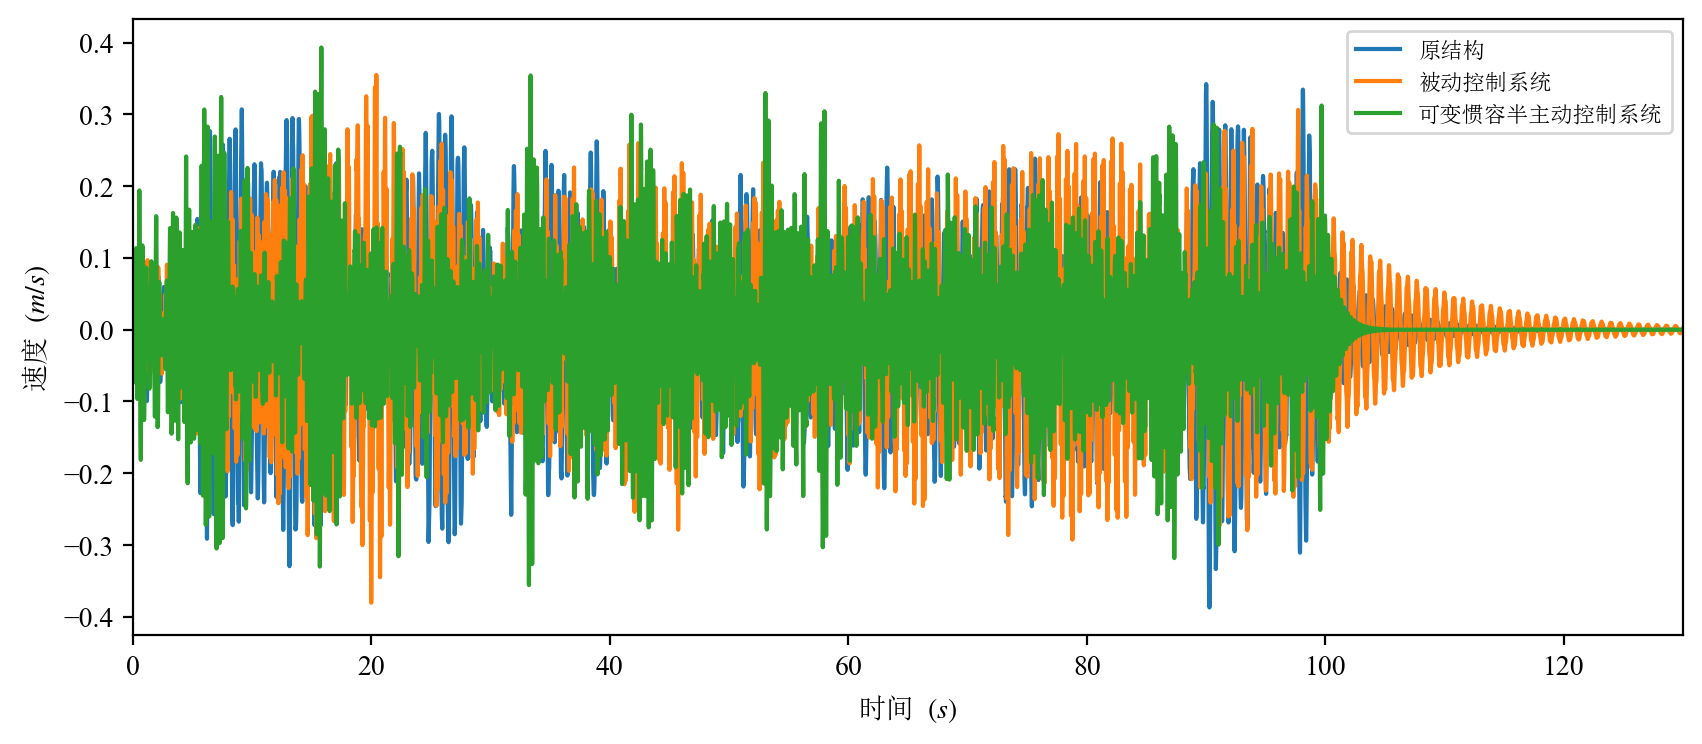

被动控制速度减震比：0.9830523944194677
半主动控制速度减震比：1.0163225534854128


In [200]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dy0.reshape(-1), label="原结构")
plt.plot(t_s, du1[0, :], label="被动控制系统")
plt.plot(t_s, dy2, label="可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"速度对比"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制速度减震比：{}".format(max(abs(du1[0, :])) / max(abs(dy0.reshape(-1)))))
print("半主动控制速度减震比：{}".format(max(abs(dy2)) / max(abs(dy0.reshape(-1)))))

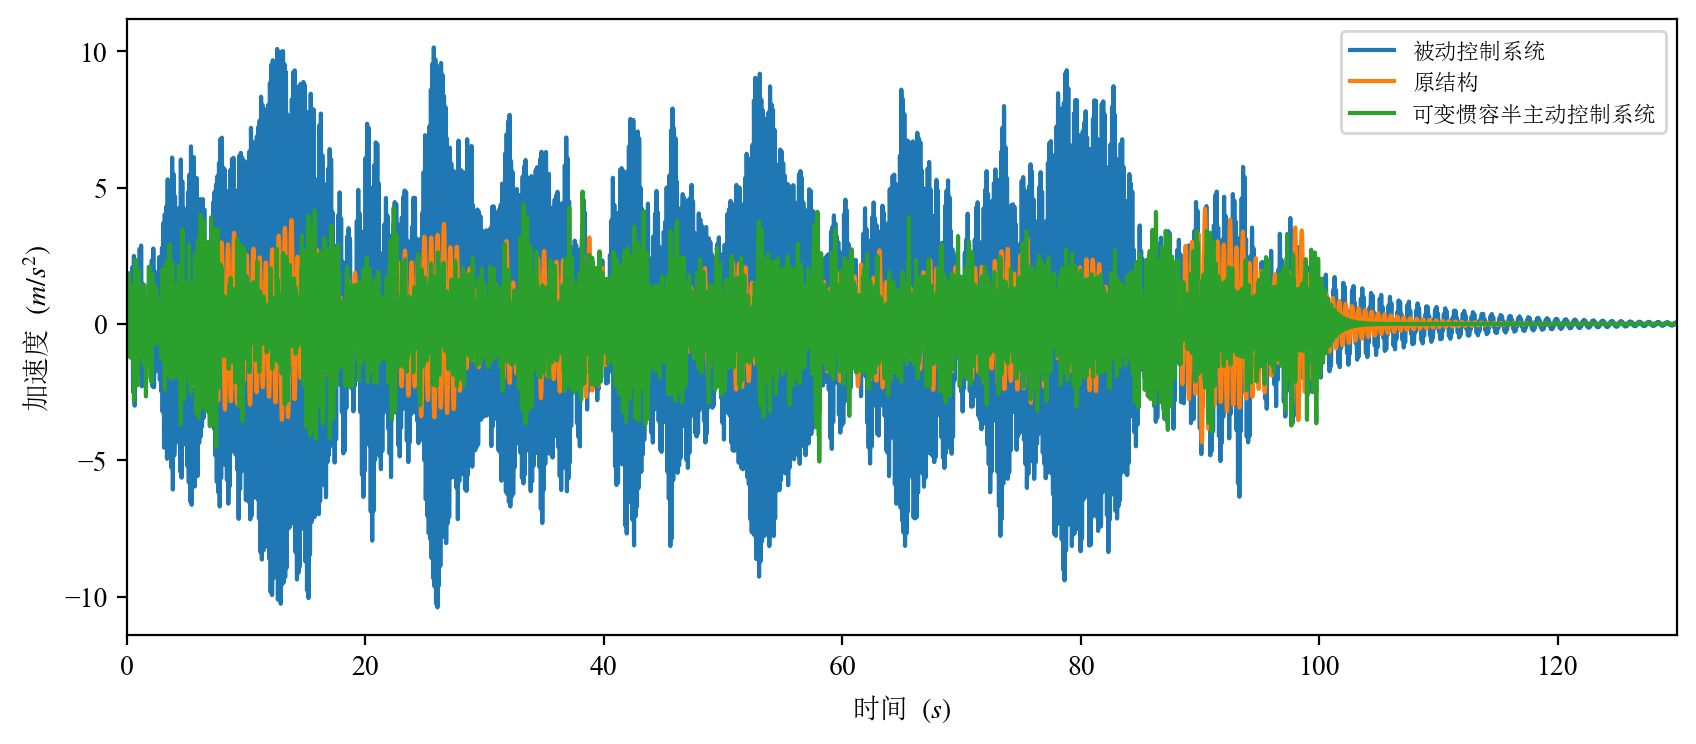

被动控制加速度减震比：2.39483762008369
半主动控制加速度减震比：1.1630479404503826


In [201]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddu1_ab[0, :], label="被动控制系统")
plt.plot(t_s, ddy0_ab.reshape(-1), label="原结构")
plt.plot(t_s, ddy2_ab, label="可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s^2)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"加速度对比"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制加速度减震比：{}".format(max(abs(ddu1_ab[0, :])) / max(abs(ddy0_ab.reshape(-1)))))
print("半主动控制加速度减震比：{}".format(max(abs(ddy2_ab)) / max(abs(ddy0_ab.reshape(-1)))))

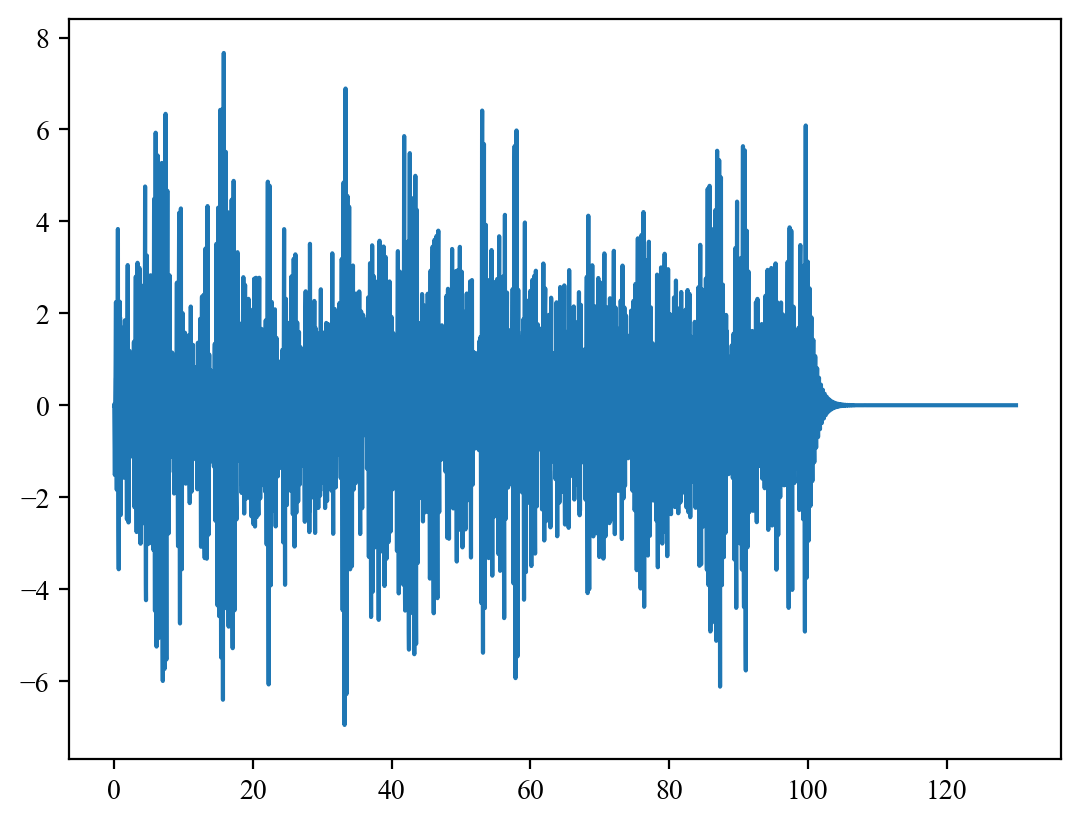

In [202]:
plt.plot(t_s, ft)

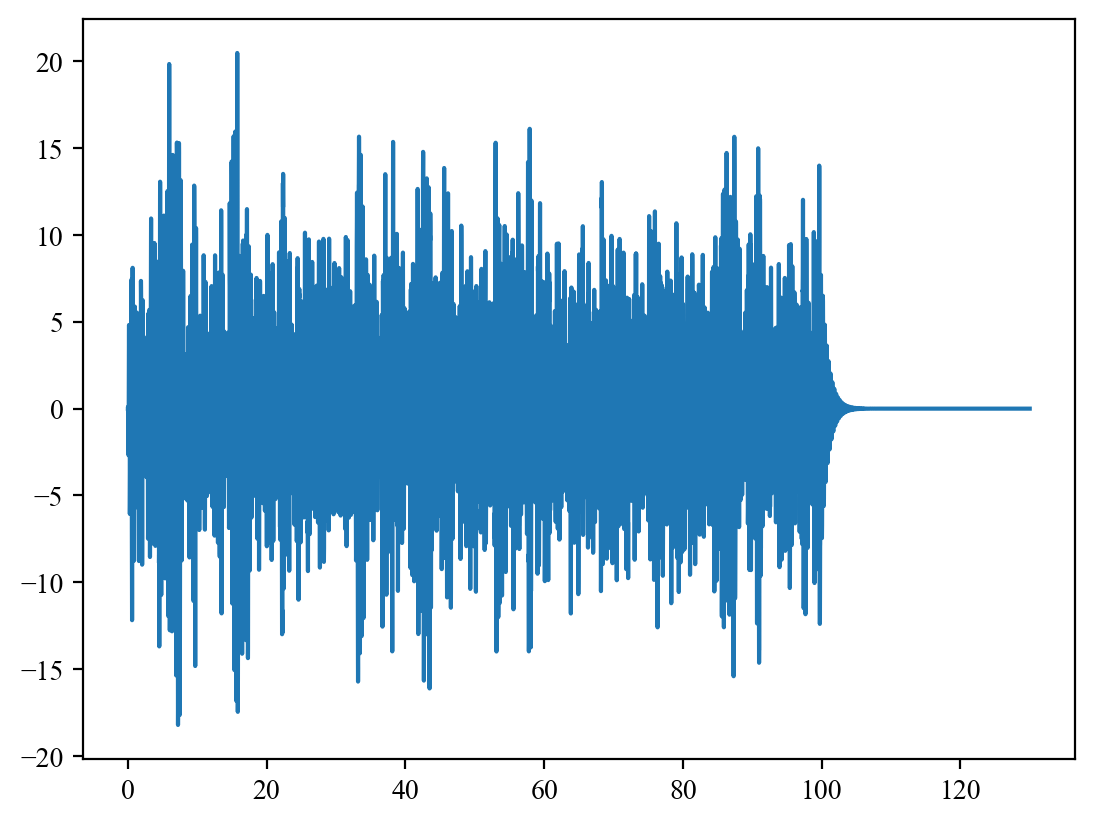

In [203]:
plt.plot(t_s, ddud)

In [204]:
y = u2[0, :]
dy = u2[1, :]
ddy_ab = du2[1, :]

In [205]:
length = len(y)
numpy_data = np.zeros([length, 9])
data = pd.DataFrame(data=numpy_data, columns=["str_cur_disp", "str_cur_vel", "str_cur_acc", "str_pre_disp", "str_pre_vel", "str_pre_acc", "ft_pre", "ft_cur", "ft_next"])

In [206]:
# 构造样本数据

for i in range(1, length - 1):
    row_data = np.array([y[i], dy[i], ddy_ab[i], y[i - 1], dy[i - 1], ddy_ab[i - 1], ft[i - 1], ft[i], ft[i + 1]])
    data.loc[i - 1] = row_data

In [207]:
x_label = ["str_cur_disp", "str_cur_vel", "str_cur_acc", "str_pre_disp", "str_pre_vel", "str_pre_acc", "ft_pre", "ft_cur"]
y_label = "ft_next"
X = data.loc[:, x_label].values
y = data.loc[:, y_label].values

In [208]:
data_len = data.shape[0]
train_len = int(0.6 * data_len)
X_train = X[0: train_len, :]
X_test = X[train_len: data_len, :]
y_train = y[0: train_len]
y_test = y[train_len: data_len]

In [209]:
# 特征标准化，采用最大最小值标准化，转化后的值范围（0,1）
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
new_X_train = X_train
new_X_test = X_test
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
# normalizer = Normalizer(copy=True, norm='l2').fit(new_X_train)
# new_X_train = normalizer.transform(new_X_train)
# new_X_test = normalizer.transform(new_X_test)
ss = StandardScaler().fit(new_X_train)
new_X_train = ss.transform(new_X_train)
new_X_test = ss.transform(new_X_test)

In [210]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

In [211]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """预测目标与真实目标的散点图。"""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],'--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [212]:
GBoost.fit(new_X_train, y_train)


train_pred = GBoost.predict(new_X_train)
pred = GBoost.predict(new_X_test)
print(rmsle(y_train, train_pred))


0.2641263183814953


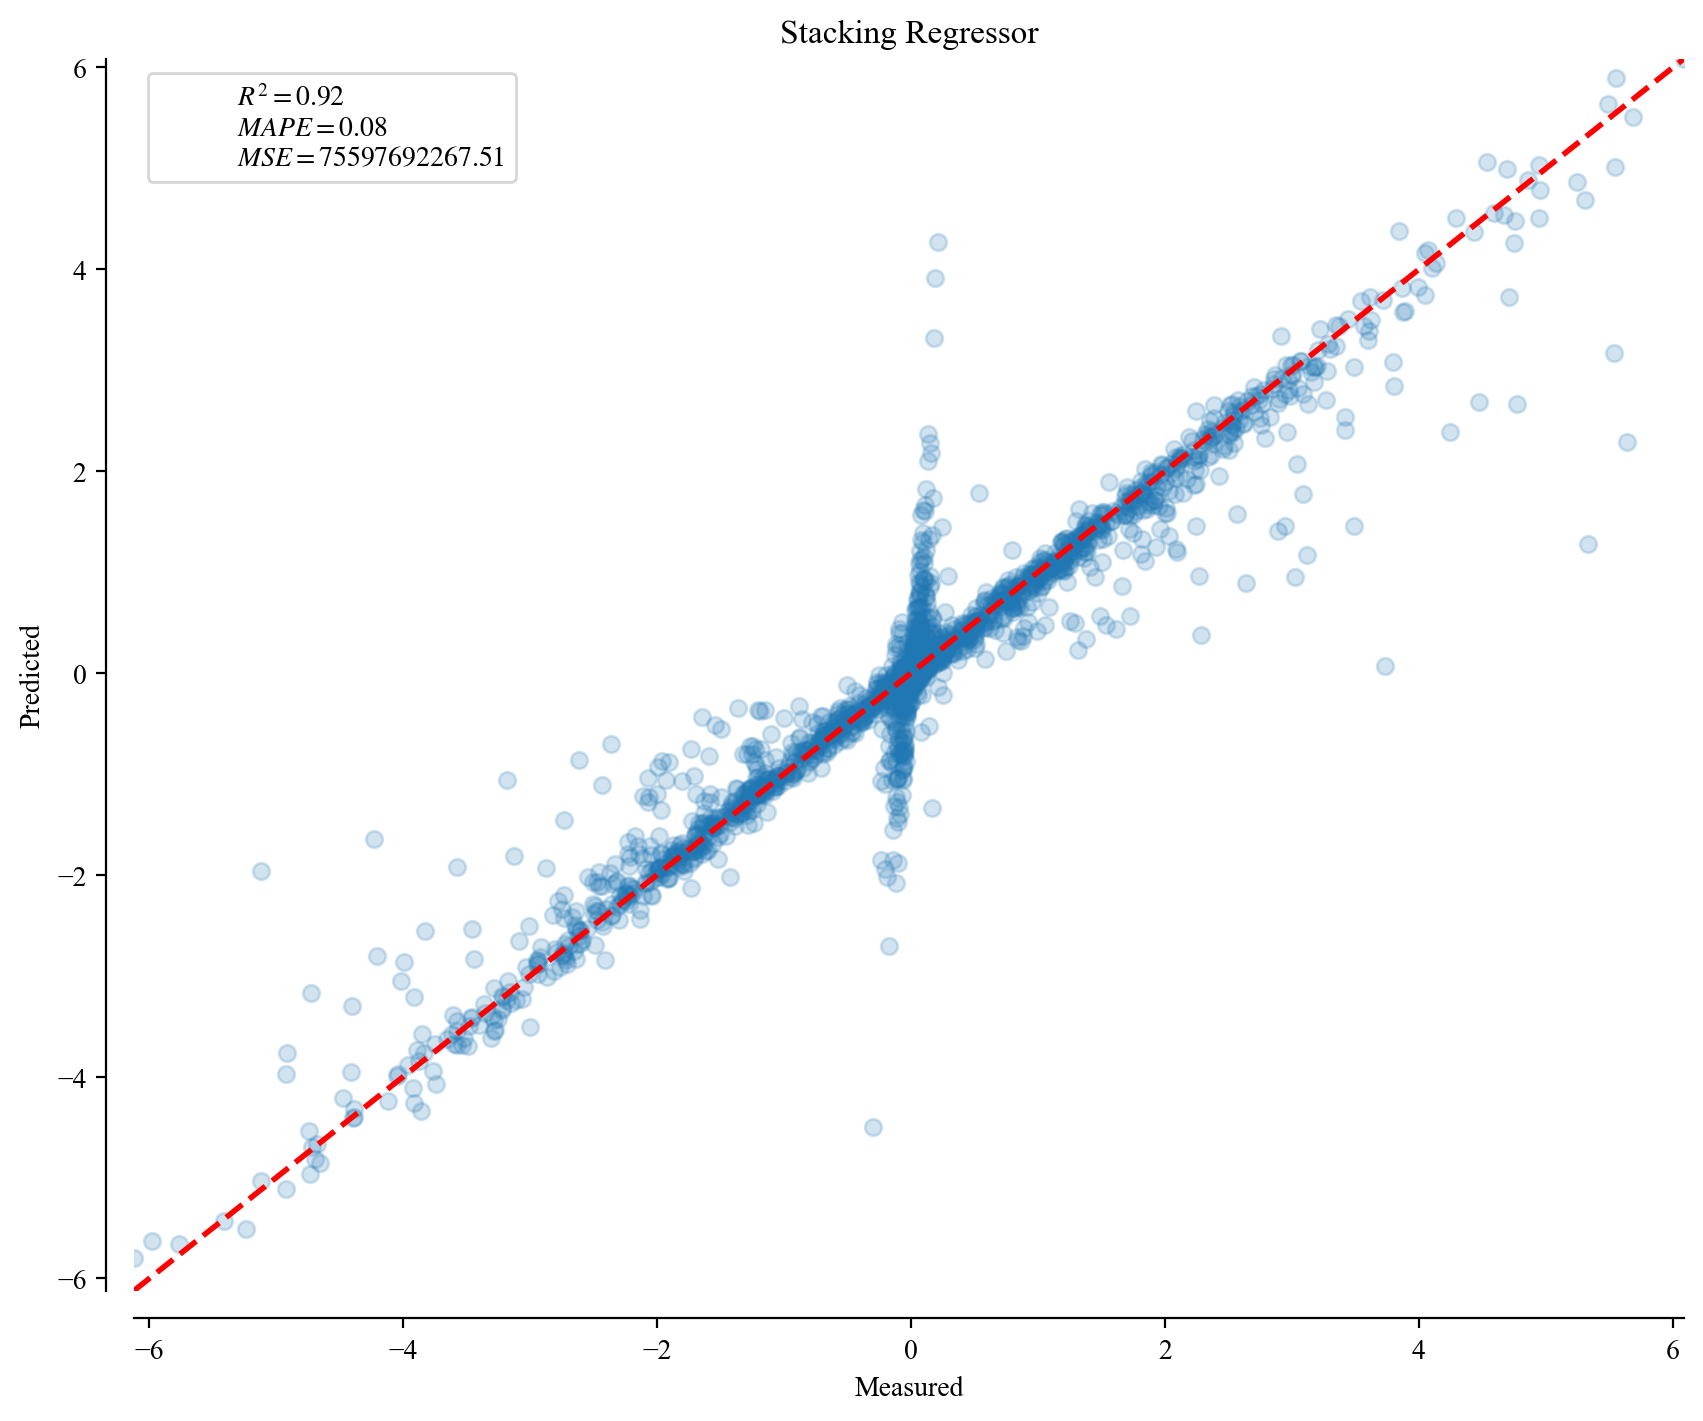

In [213]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)

plt.figure(figsize=(10,8))
ax = plt.gca()
plot_regression_results(
        ax, y_test, pred,
        "Stacking Regressor",
        (r'$R^2={:.2f}$' + '\n' + r'$MAPE={:.2f}$' + '\n' + r'$MSE={:.2f}$')
        .format(r2, mse, mape))


In [214]:
# 半主动控制结构
u2_ml = np.zeros([2, wave_len_s])
du2_ml = np.zeros([2, wave_len_s])
du2_ml[1, 0] = -wave_s[0]
F = np.zeros([2, wave_len_s])
ft_ml = np.zeros(wave_len_s)
ud_ml = np.zeros(wave_len_s)
dud_ml = np.zeros(wave_len_s)
ddud_ml = np.zeros(wave_len_s)
fmax_ml = np.zeros(wave_len_s)
fmin_ml = np.zeros(wave_len_s)
fa_ml = np.zeros(wave_len_s)
ud_ml_pre = 0
dud_ml_pre = 0

str_pre_disp = 0
str_pre_vel = 0
str_pre_acc = 0
str_cur_disp = 0
str_cur_vel = 0
str_cur_acc = 0
ft_ml_pre = 0
ft_ml_next = 0

y2_ml = np.zeros(wave_len_s)
dy2_ml = np.zeros(wave_len_s)
ddy2_ml = np.zeros(wave_len_s)
ddy2_ab_ml = np.zeros(wave_len_s)
ag_pre = 0
for i in range(wave_len_s - 1):
    str_cur_disp = y2_ml[i - 1]
    str_cur_vel = dy2_ml[i - 1]
    str_cur_acc = ddy2_ab_ml[i - 1]
    ft_ml_cur = ft_ml[i - 1]
    x = np.array([str_cur_disp, str_cur_vel, str_cur_acc, str_pre_disp, str_pre_vel, str_pre_acc, ft_ml_pre, ft_ml_cur], ndmin=2)
    x = ss.transform(x)
    ft_ml[i] = GBoost.predict(x)[0]
    ft_ml_pre = ft_ml_cur
    str_pre_disp = str_cur_disp
    str_pre_vel = str_cur_vel
    str_pre_acc = str_cur_acc

    ud_ml[i] = u2_ml[0, i] - ft_ml[i] / kd  # 当前惯容位移
    dud_ml[i] = (ud_ml[i] - ud_ml[i - 1]) / dt_s  # 当前惯容速度
    ddud_ml[i] = (dud_ml[i] - dud_ml[i - 1]) / dt_s  # 当前惯容加速度

    # 当前出力上限
    fmax_ml[i] = max(
        [min_max * ddud_ml[i] + cd_max * dud_ml[i],
         min_min * ddud_ml[i] + cd_min * dud_ml[i]])
    # 当前出力下限
    fmin_ml[i] = min([min_max * ddud_ml[i] + cd_max * dud_ml[i],
                   min_min * ddud_ml[i] + cd_min * dud_ml[i]])
    while True:
        if ft_ml[i] < fmin_ml[i]:
            ft_ml[i] = fmin_ml[i]
        elif ft_ml[i] > fmax_ml[i]:
            ft_ml[i] = fmax_ml[i]
        else:
            fa_ml[i] = ft_ml[i]
            break
        ud_ml[i] = u2_ml[0, i] - ft_ml[i] / kd  # 当前惯容位移
        dud_ml[i] = (ud_ml[i] - ud_ml[i - 1]) / dt_s  # 当前惯容速度
        ddud_ml[i] = (dud_ml[i] - dud_ml[i - 1]) / dt_s  # 当前惯容加速度

        # 当前出力上限
        fmax_ml[i] = max(
            [min_max * ddud_ml[i] + cd_max * dud_ml[i],
             min_min * ddud_ml[i] + cd_min * dud_ml[i]])
        # 当前出力下限
        fmin_ml[i] = min([min_max * ddud_ml[i] + cd_max * dud_ml[i],
                       min_min * ddud_ml[i] + cd_min * dud_ml[i]])

    # ud_ml_pre = ud_ml[i]
    # dud_ml_pre = dud_ml[i]
    # Newmark_beta法
    ag = wave_s[i] + fa_ml[i] / m
    z_acc = ag - ag_pre
    z_y = (-m * z_acc + (4 / dt) * m * dy2_ml[i] + 2 * m * ddy2_ml[i] + 2 * c * dy2_ml[i]) / (k + 2 * c / dt + m * 4 / (dt ** 2))
    y2_ml[i + 1] = y2_ml[i] + z_y
    z_dy = 2 / dt * z_y - 2 * dy2_ml[i]
    dy2_ml[i + 1] = dy2_ml[i] + z_dy
    z_ddy = 4 / (dt ** 2) * z_y - (4 / dt) * dy2_ml[i] - 2 * ddy2_ml[i]
    ddy2_ml[i + 1] = ddy2_ml[i] + z_ddy
    ddy2_ab_ml[i] = ddy2_ml[i] + ag

    ag_pre = ag
    u2_ml[0, i + 1] = y2_ml[i + 1]
    u2_ml[1, i + 1] = dy2_ml[i + 1]
    du2_ml[0, i] = dy2_ml[i]
    du2_ml[1, i] = ddy2_ab_ml[i]

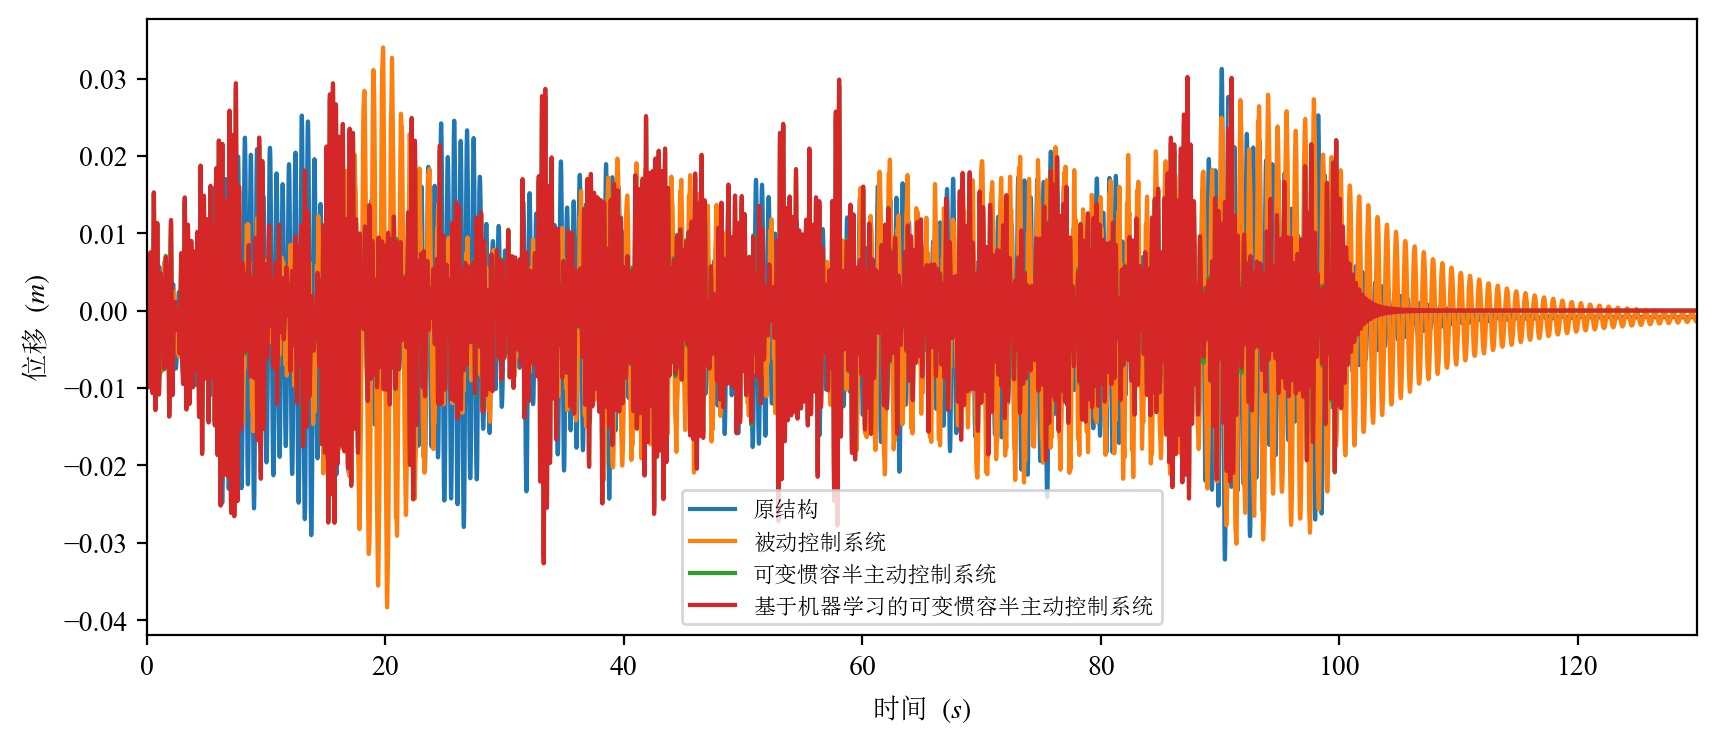

被动控制位移减震比：1.1922820241720877
半主动控制位移减震比：0.9828209628415592
机器学习半主动控制位移减震比：1.0156184968699982


In [215]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, y0.reshape(-1), label="原结构")
plt.plot(t_s, u1[0, :], label="被动控制系统")
plt.plot(t_s, y2, label="可变惯容半主动控制系统")
plt.plot(t_s, y2_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"位移对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制位移减震比：{}".format(max(abs(u1[0, :])) / max(abs(y0.reshape(-1)))))
print("半主动控制位移减震比：{}".format(max(abs(y2)) / max(abs(y0.reshape(-1)))))
print("机器学习半主动控制位移减震比：{}".format(max(abs(y2_ml)) / max(abs(y0.reshape(-1)))))

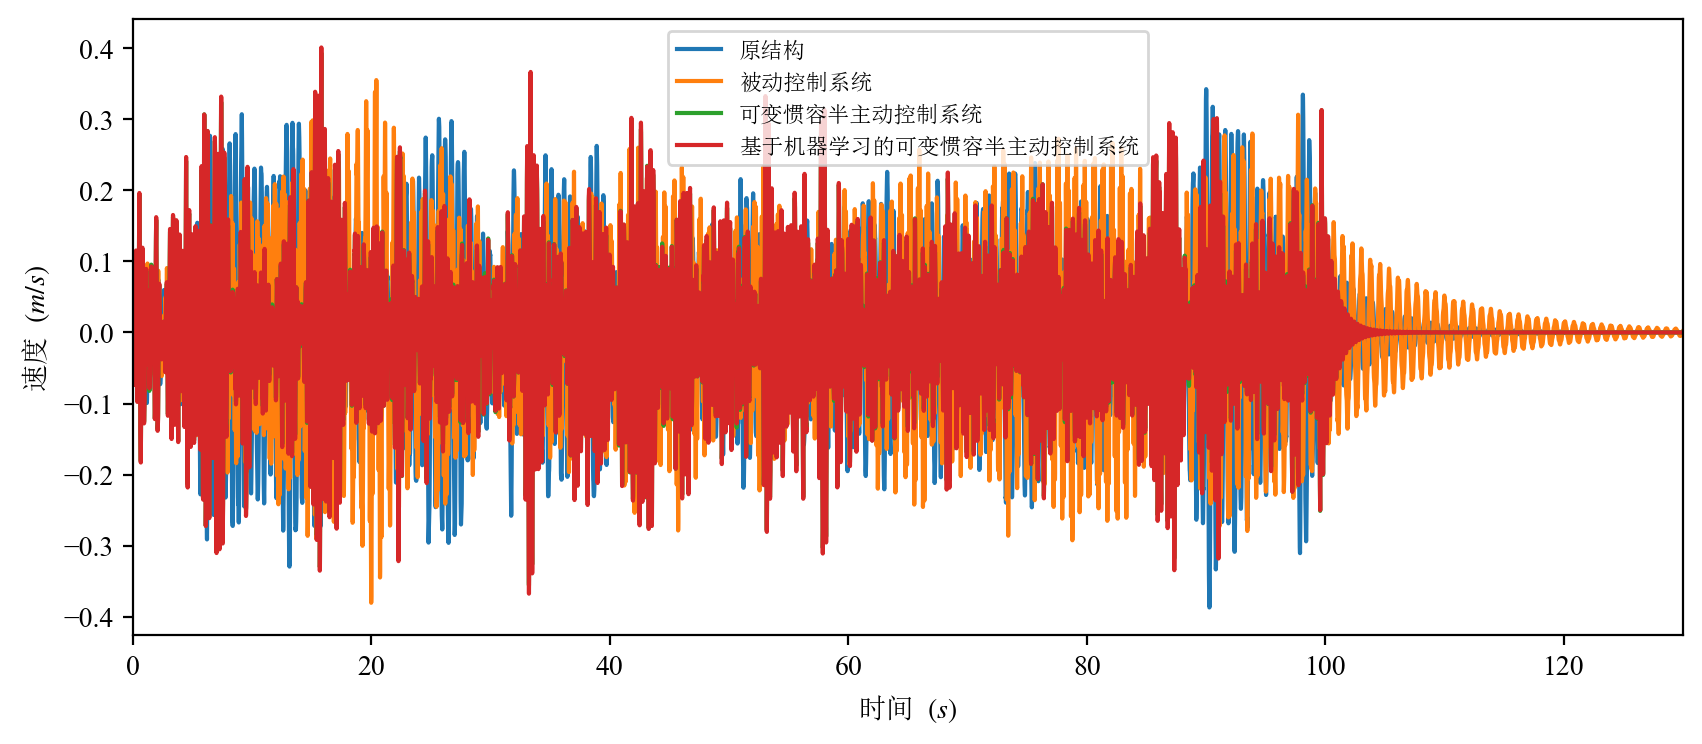

被动控制速度减震比：0.9830523944194677
半主动控制速度减震比：1.0163225534854128
机器学习半主动速度位移减震比：1.03617482776009


In [216]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dy0.reshape(-1), label="原结构")
plt.plot(t_s, du1[0, :], label="被动控制系统")
plt.plot(t_s, dy2, label="可变惯容半主动控制系统")
plt.plot(t_s, dy2_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"速度对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制速度减震比：{}".format(max(abs(du1[0, :])) / max(abs(dy0.reshape(-1)))))
print("半主动控制速度减震比：{}".format(max(abs(dy2)) / max(abs(dy0.reshape(-1)))))
print("机器学习半主动速度位移减震比：{}".format(max(abs(dy2_ml)) / max(abs(dy0.reshape(-1)))))

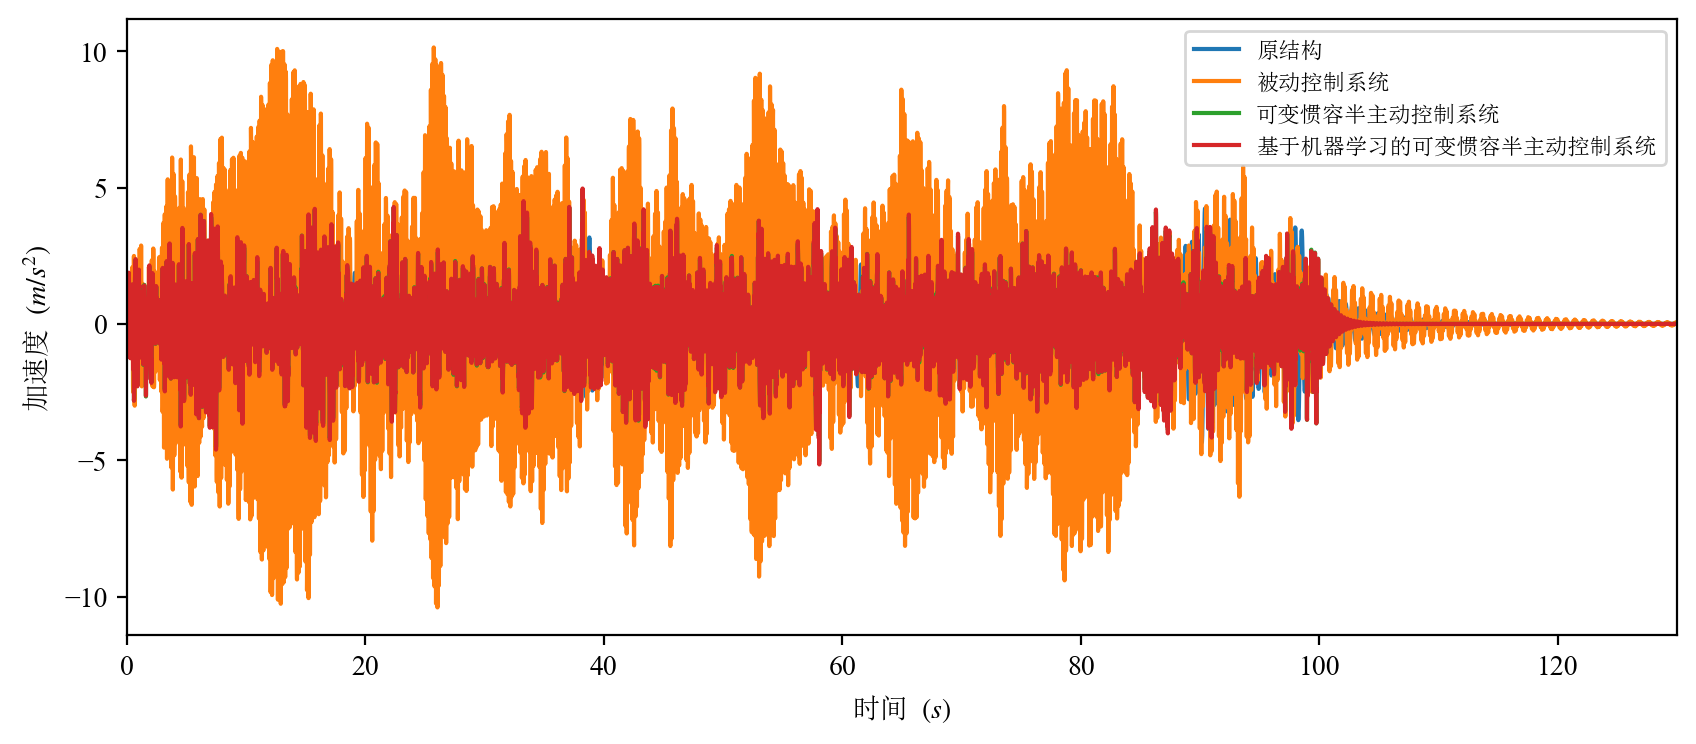

被动控制加速度减震比：2.39483762008369
半主动控制加速度减震比：1.1630479404503826
机器学习半主动加速度位移减震比：1.1869096165721509


In [217]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddy0_ab.reshape(-1), label="原结构")
plt.plot(t_s, ddu1_ab[0, :], label="被动控制系统")
plt.plot(t_s, ddy2_ab, label="可变惯容半主动控制系统")
plt.plot(t_s, ddy2_ab_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s^2)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"加速度对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制加速度减震比：{}".format(max(abs(ddu1_ab[0, :])) / max(abs(ddy0_ab.reshape(-1)))))
print("半主动控制加速度减震比：{}".format(max(abs(ddy2_ab)) / max(abs(ddy0_ab.reshape(-1)))))
print("机器学习半主动加速度位移减震比：{}".format(max(abs(ddy2_ab_ml)) / max(abs(ddy0_ab.reshape(-1)))))

(0.0, 129.98)

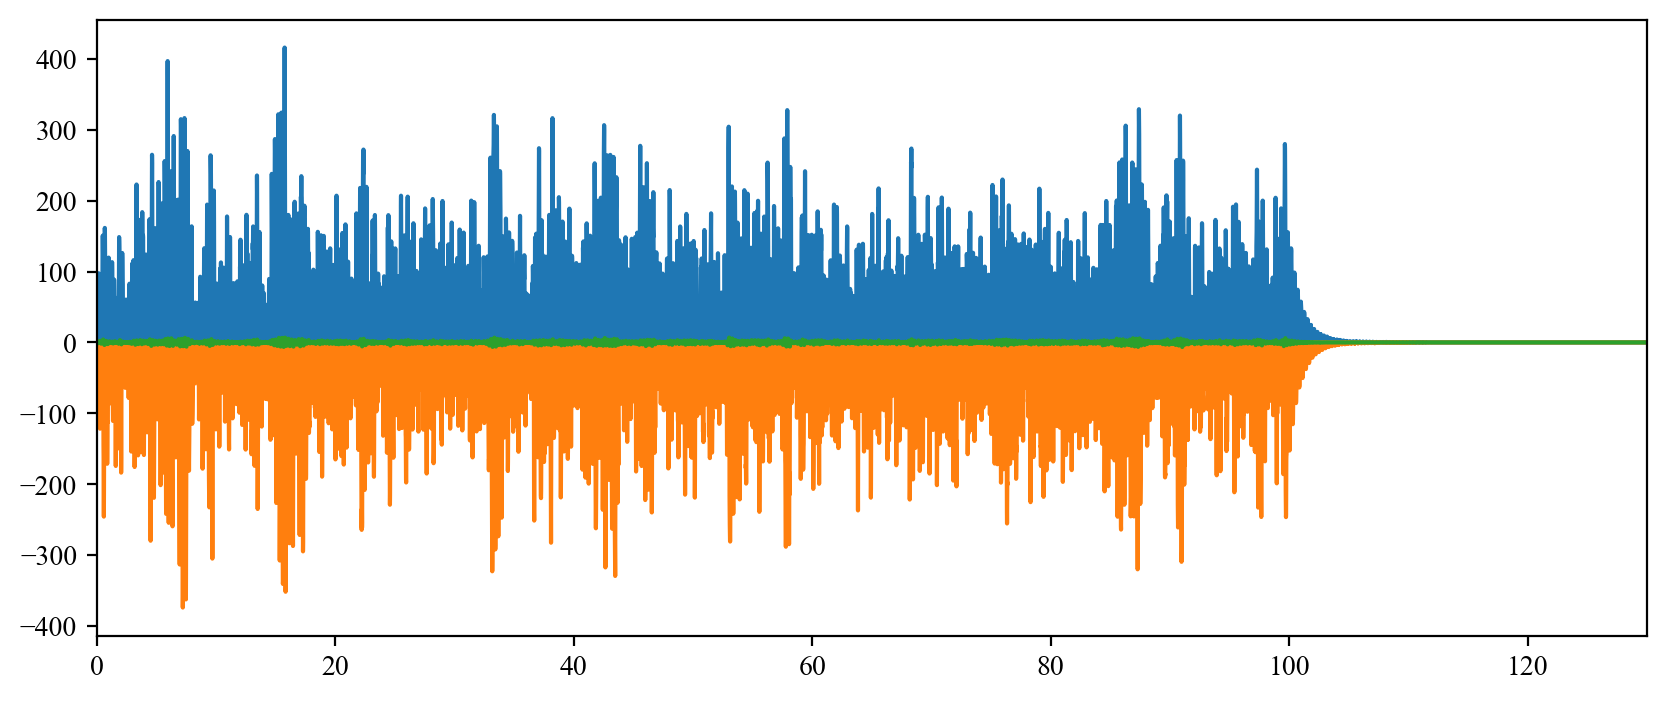

In [218]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, fmax_ml)
plt.plot(t_s, fmin_ml)
plt.plot(t_s, fa_ml)
plt.xlim([0, max(t_s)])

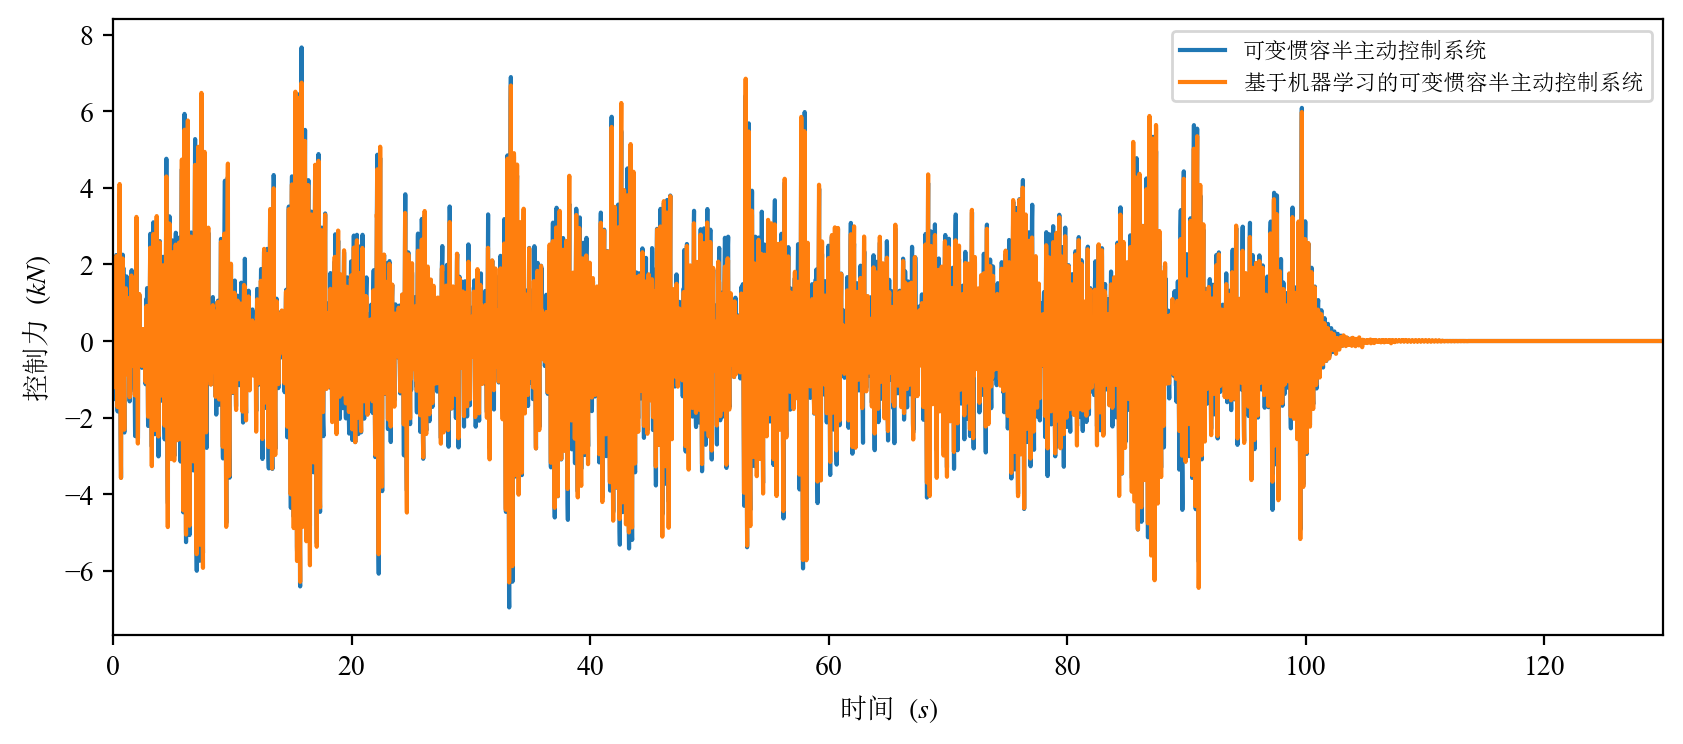

In [219]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, fa, label="可变惯容半主动控制系统")
plt.plot(t_s, fa_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'控制力 $(kN)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"控制力对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

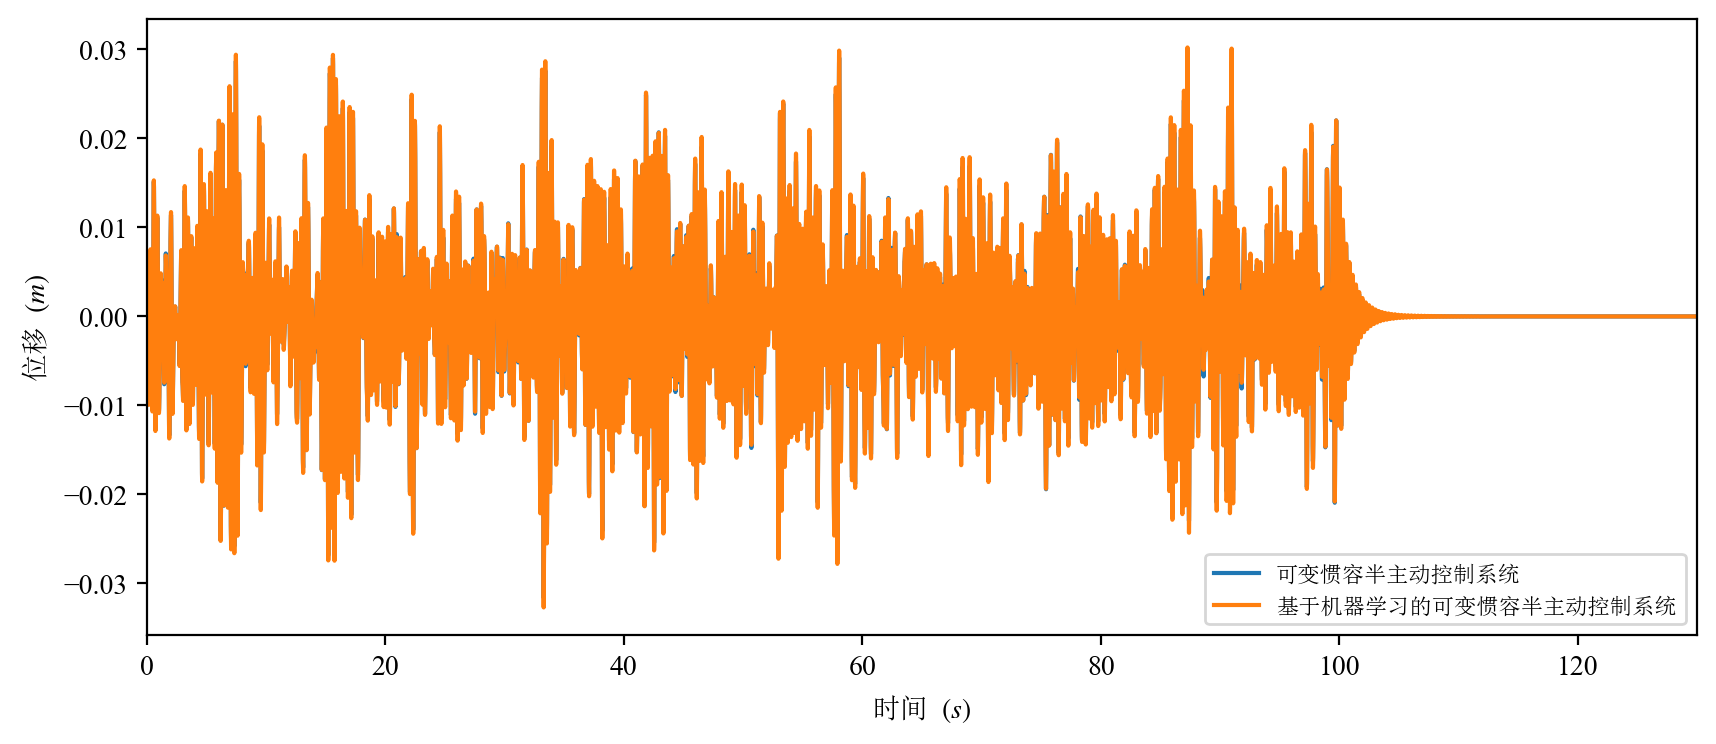

In [220]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ud, label="可变惯容半主动控制系统")
plt.plot(t_s, ud_ml, label="基于机器学习的可变惯容半主动控制系统")

plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件位移对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

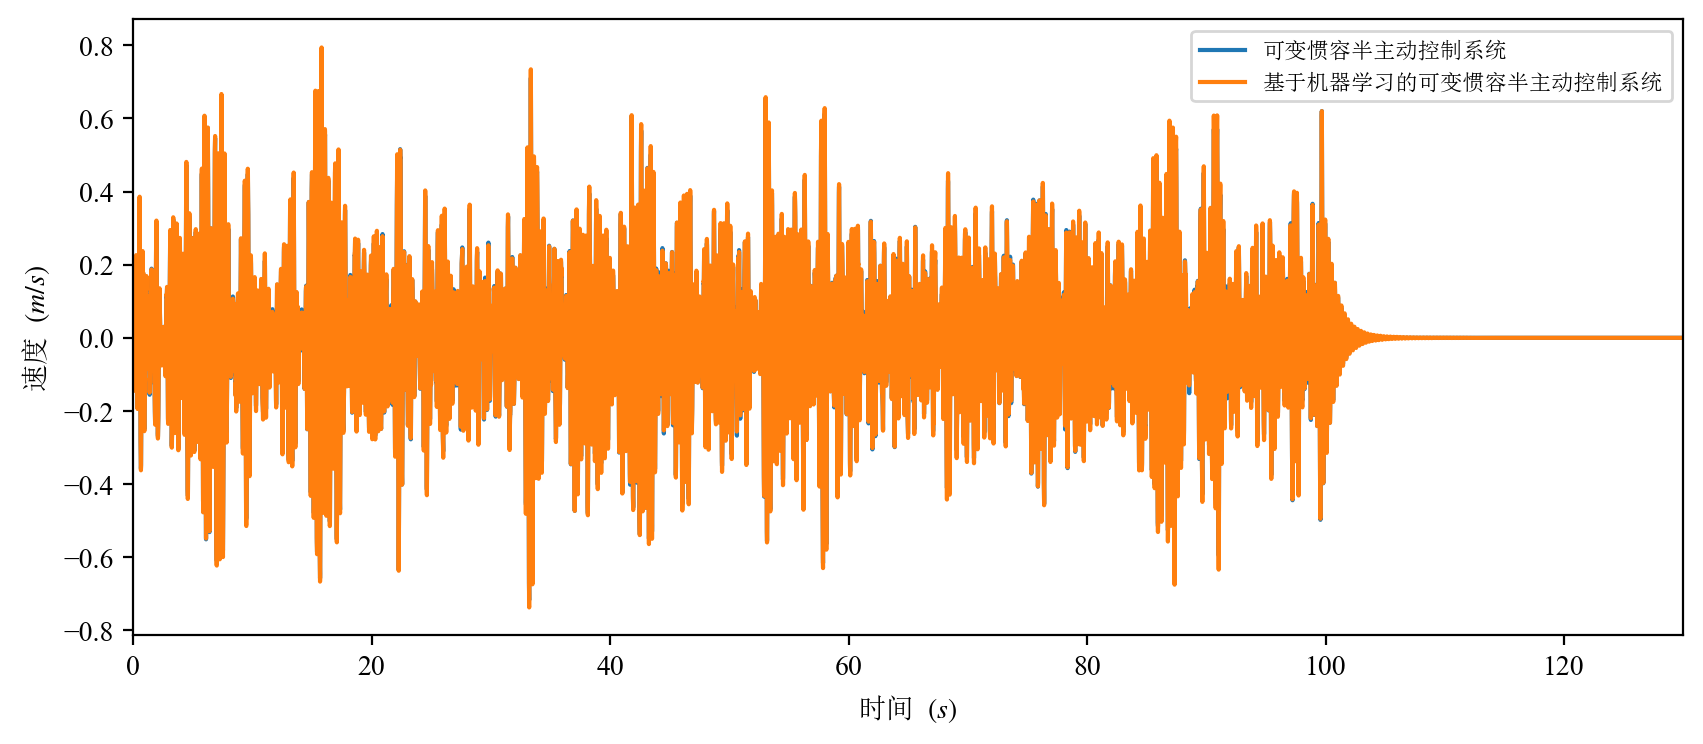

In [221]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dud, label="可变惯容半主动控制系统")
plt.plot(t_s, dud_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件速度对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

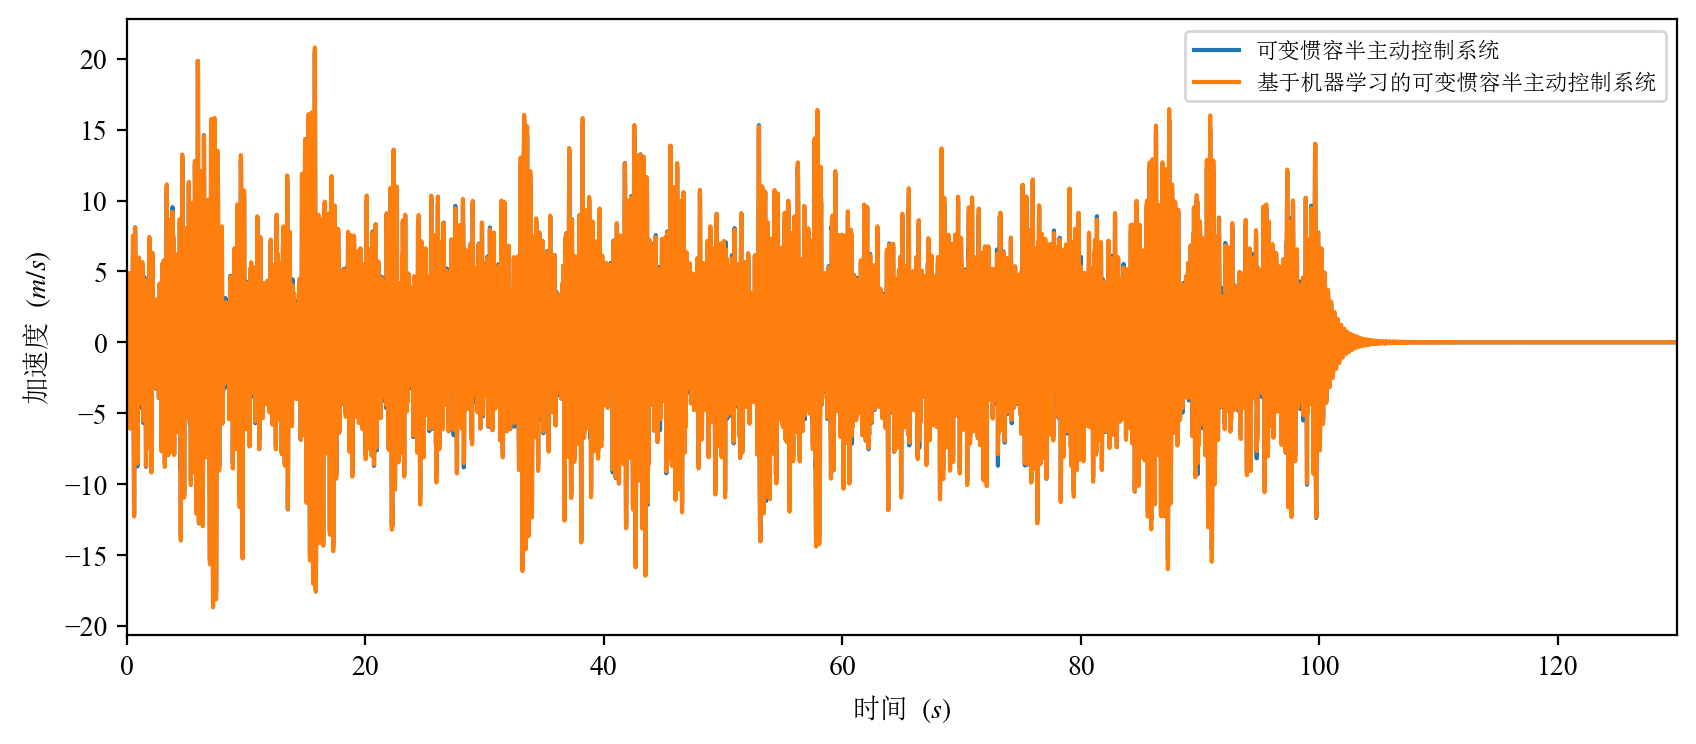

In [222]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddud, label="可变惯容半主动控制系统")
plt.plot(t_s, ddud_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件加速度对比_ml"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [223]:
# 用另外一条波
wave = 0
dt = 0
name = "RSN55_SFERN_BVP090.AT2"
root = "./waves"
print(name)
wave_name = name.split('.')[0]
if name.endswith(".AT2"):
    filename = os.path.join(root, name)
    with open(filename, 'r') as fo:
        for i in range(3):
            fo.readline()
        line = fo.readline()
        target = re.search(r'DT= *(.*) *SEC', line, re.I | re.M)
        dt = float(target.group(1))
        wave = pd.read_table(filename, skiprows=4, sep="  ", header=None, engine='python')
        wave = wave.fillna(0)
        wave = wave.values
        size = wave.size
        wave = wave.reshape((size,))
if name.endswith(".txt"):
    filename = os.path.join(root, name)
    wave = np.loadtxt(filename)
    dt = 0.02
wave = wave / max(abs(wave)) * 0.3 * 9.8
wave_len = len(wave)
time = np.arange(0, wave_len * dt, dt)

RSN55_SFERN_BVP090.AT2


In [224]:
# 加速度插值
dt_s = dt * 1
t_s = np.arange(0, max(time) + 10, dt_s)
wave_s = np.interp(t_s, time, wave)
wave_len_s = len(wave_s)
wave_len_s

7329

In [225]:
M0 = np.array(m, ndmin=2, dtype=float)
C0 = np.array(c, ndmin=2, dtype=float)
K0 = np.array(k, ndmin=2, dtype=float)
E0 = np.array(1, ndmin=2, dtype=float)
y0, dy0, ddy0, ddy0_ab = newmark(K0, M0, C0, wave_s, dt_s, E0)

In [226]:
# 被动控制结构
M = np.array([[m, 0], [0, md0]], ndmin=2, dtype=float)
K = np.array([[k + kd0, -kd0], [-kd0, kd0]], ndmin=2, dtype=float)
C = np.array([[c, 0], [0, cd0]], ndmin=2, dtype=float)
E = np.array([[1], [0]], ndmin=2, dtype=float)
u1, du1, _, ddu1_ab = newmark(K, M, C, wave_s, dt_s, E)

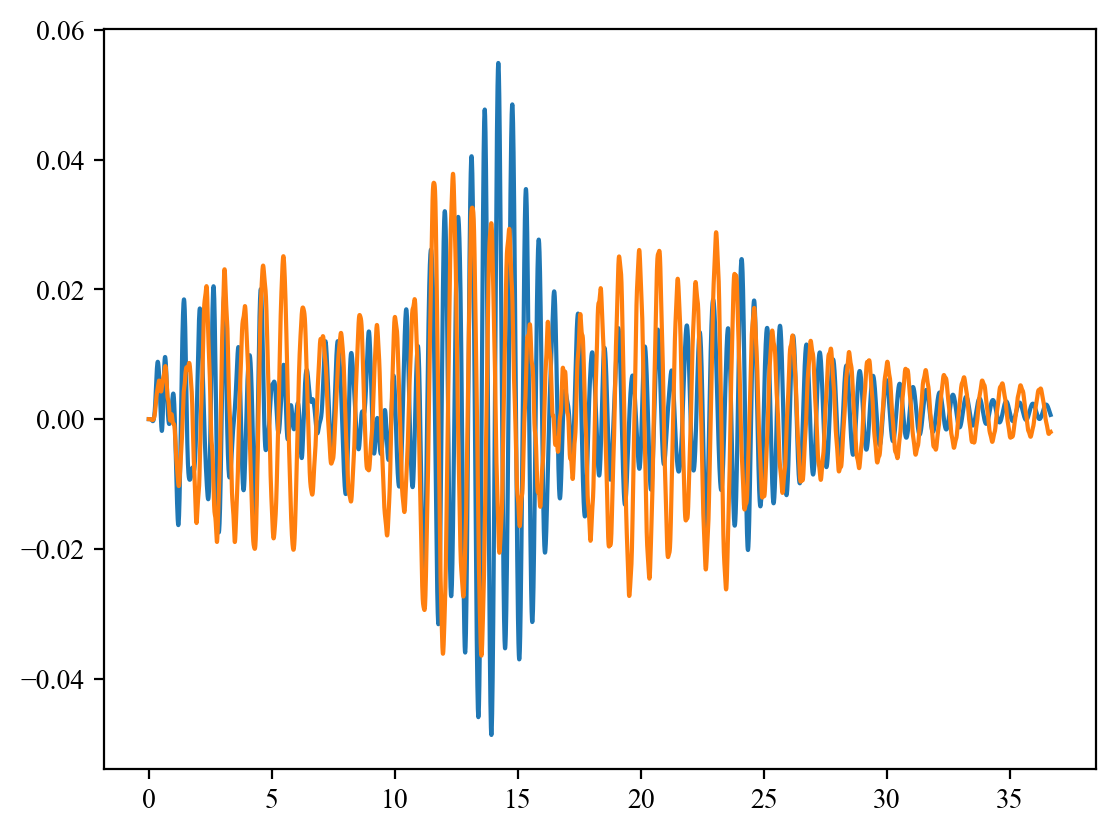

In [227]:
plt.plot(t_s, y0.reshape(-1))
plt.plot(t_s, u1[0, :])

In [228]:
# 半主动控制结构
u2 = np.zeros([2, wave_len_s])
du2 = np.zeros([2, wave_len_s])
du2[1, 0] = -wave_s[0]
F = np.zeros([2, wave_len_s])
ft = np.zeros(wave_len_s)
ud = np.zeros(wave_len_s)
dud = np.zeros(wave_len_s)
ddud = np.zeros(wave_len_s)
fmax = np.zeros(wave_len_s)
fmin = np.zeros(wave_len_s)
fa = np.zeros(wave_len_s)
ud_pre = 0
dud_pre = 0

y2 = np.zeros(wave_len_s)
dy2 = np.zeros(wave_len_s)
ddy2 = np.zeros(wave_len_s)
ddy2_ab = np.zeros(wave_len_s)
ag_pre = 0

for i in range(wave_len_s - 1):
    # p = np.array([[0], [-wave_s[i]]])  # 当前荷载向量
    F[:, i, None] = np.dot(D, u2[:, i, None])  # 当前反馈力
    ft[i] = F[1, i]  # 当前目标出力
    ud[i] = u2[0, i] - ft[i] / kd  # 当前惯容位移
    dud[i] = (ud[i] - ud_pre) / dt_s  # 当前惯容速度
    ddud[i] = (dud[i] - dud_pre) / dt_s  # 当前惯容加速度


    # 当前出力上限
    fmax[i] = max(
        [min_max * ddud[i] + cd_max * dud[i],
         min_max * ddud[i] + cd_min * dud[i],
         min_min * ddud[i] + cd_max * dud[i],
         min_min * ddud[i] + cd_min * dud[i]])
    # 当前出力下限
    fmin[i] = min([min_max * ddud[i] + cd_max * dud[i],
                   min_max * ddud[i] + cd_min * dud[i],
                   min_min * ddud[i] + cd_max * dud[i],
                   min_min * ddud[i] + cd_min * dud[i]])
    while True:
        if ft[i] < fmin[i]:
            ft[i] = fmin[i]
        elif ft[i] > fmax[i]:
            ft[i] = fmax[i]
        else:
            fa[i] = ft[i]
            break
        ud[i] = u2[0, i] - ft[i] / kd
        dud[i] = (ud[i] - ud_pre) / dt_s  # 当前惯容速度
        ddud[i] = (dud[i] - dud_pre) / dt_s  # 当前惯容加速度
        # 当前出力上限
        fmax[i] = max(
            [min_max * ddud[i] + cd_max * dud[i],
             min_max * ddud[i] + cd_min * dud[i],
             min_min * ddud[i] + cd_max * dud[i],
             min_min * ddud[i] + cd_min * dud[i]])
        # 当前出力下限
        fmin[i] = min([min_max * ddud[i] + cd_max * dud[i],
                       min_max * ddud[i] + cd_min * dud[i],
                       min_min * ddud[i] + cd_max * dud[i],
                       min_min * ddud[i] + cd_min * dud[i]])
    ud_pre = ud[i]
    dud_pre = dud[i]
    # Newmark_beta法
    ag = wave_s[i] + fa[i] / m
    z_acc = ag - ag_pre
    z_y = (-m * z_acc + (4 / dt) * m * dy2[i] + 2 * m * ddy2[i] + 2 * c * dy2[i]) / (k + 2 * c / dt + m * 4 / (dt ** 2))
    y2[i + 1] = y2[i] + z_y
    z_dy = 2 / dt * z_y - 2 * dy2[i]
    dy2[i + 1] = dy2[i] + z_dy
    z_ddy = 4 / (dt ** 2) * z_y - (4 / dt) * dy2[i] - 2 * ddy2[i]
    ddy2[i + 1] = ddy2[i] + z_ddy
    ddy2_ab[i] = ddy2[i] + ag

    ag_pre = ag
    u2[0, i + 1] = y2[i + 1]
    u2[1, i + 1] = dy2[i + 1\
        ]
    du2[0, i + 1] = dy2[i + 1]
    du2[1, i + 1] = ddy2_ab[i + 1]
    # du2[:, i + 1, None] = np.dot(A, u2[..., i, None]) + np.dot(B, F[..., i, None])  + p
    # u2[..., i + 1] = u2[..., i] + du2[..., i + 1] * dt_s


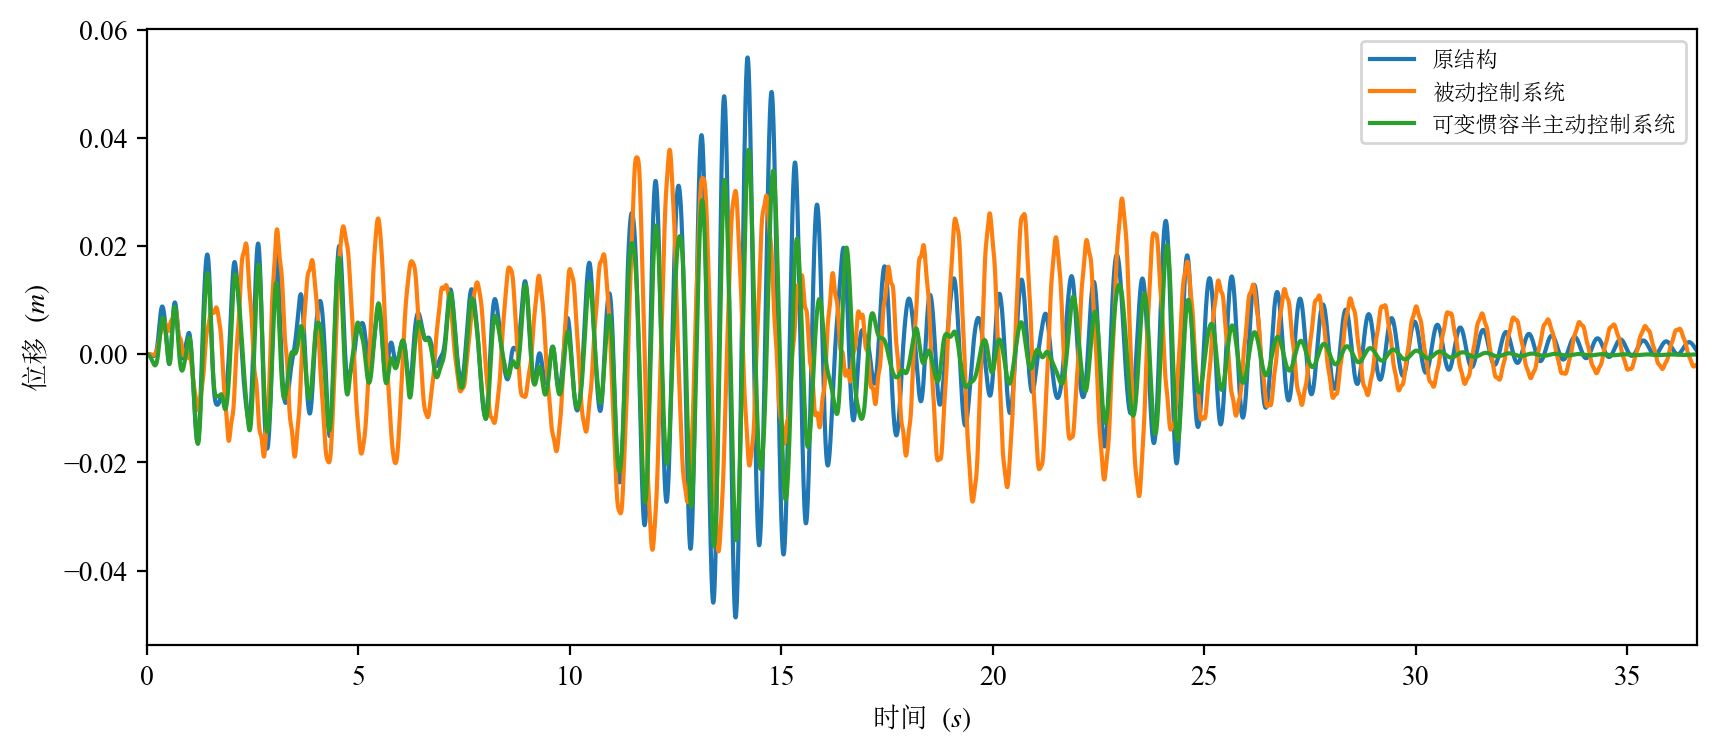

被动控制位移减震比：0.6887977163970579
半主动控制位移减震比：0.6888799604472683


In [229]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, y0.reshape(-1), label="原结构")
plt.plot(t_s, u1[0, :], label="被动控制系统")
plt.plot(t_s, y2, label="可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"位移对比_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制位移减震比：{}".format(max(abs(u1[0, :])) / max(abs(y0.reshape(-1)))))
print("半主动控制位移减震比：{}".format(max(abs(y2)) / max(abs(y0.reshape(-1)))))

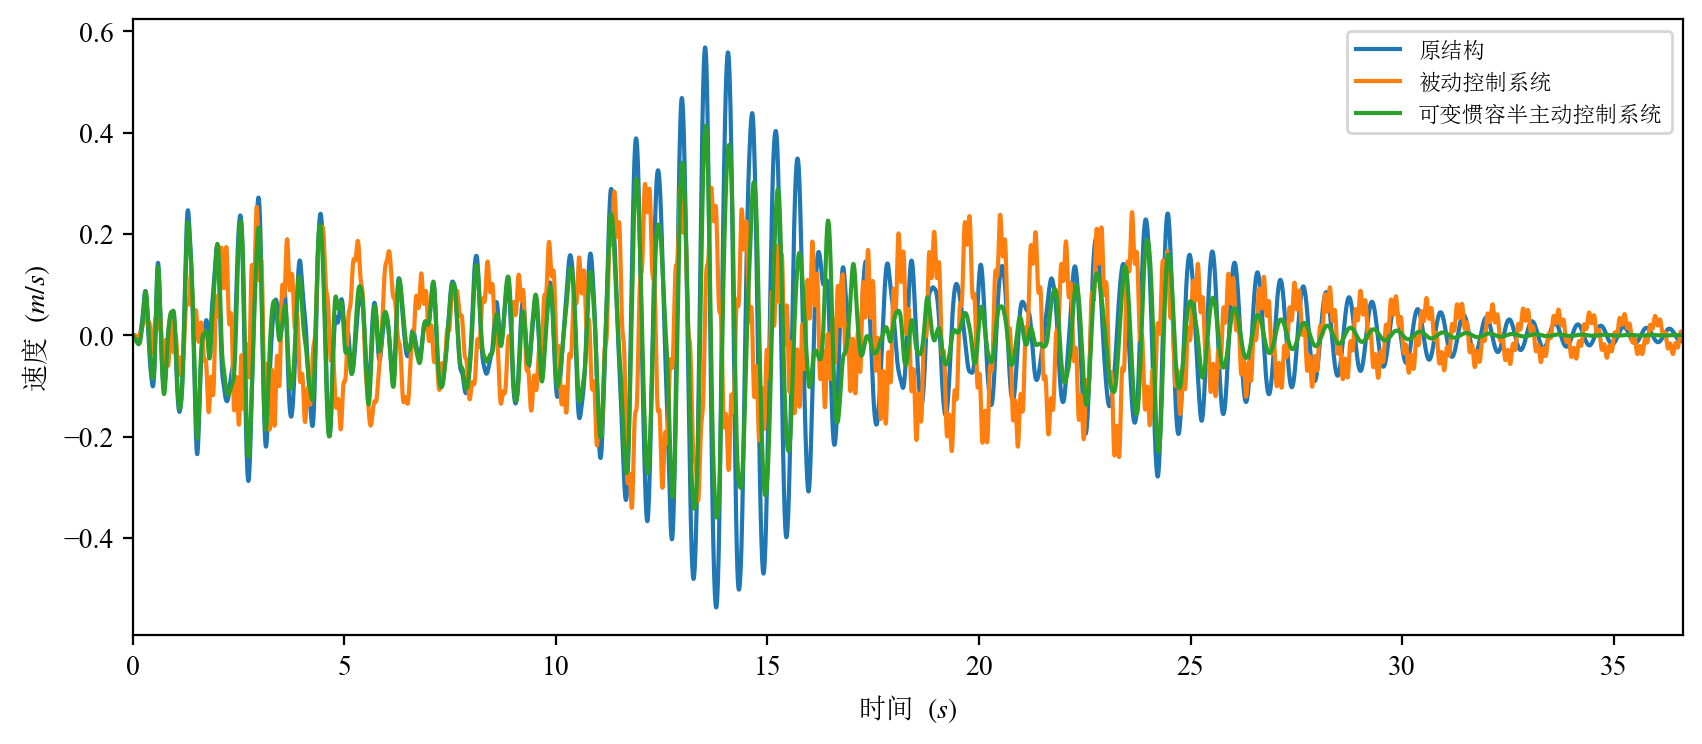

被动控制速度减震比：0.599873885597527
半主动控制速度减震比：0.7286970871232796


In [230]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dy0.reshape(-1), label="原结构")
plt.plot(t_s, du1[0, :], label="被动控制系统")
plt.plot(t_s, dy2, label="可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"速度对比_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制速度减震比：{}".format(max(abs(du1[0, :])) / max(abs(dy0.reshape(-1)))))
print("半主动控制速度减震比：{}".format(max(abs(dy2)) / max(abs(dy0.reshape(-1)))))

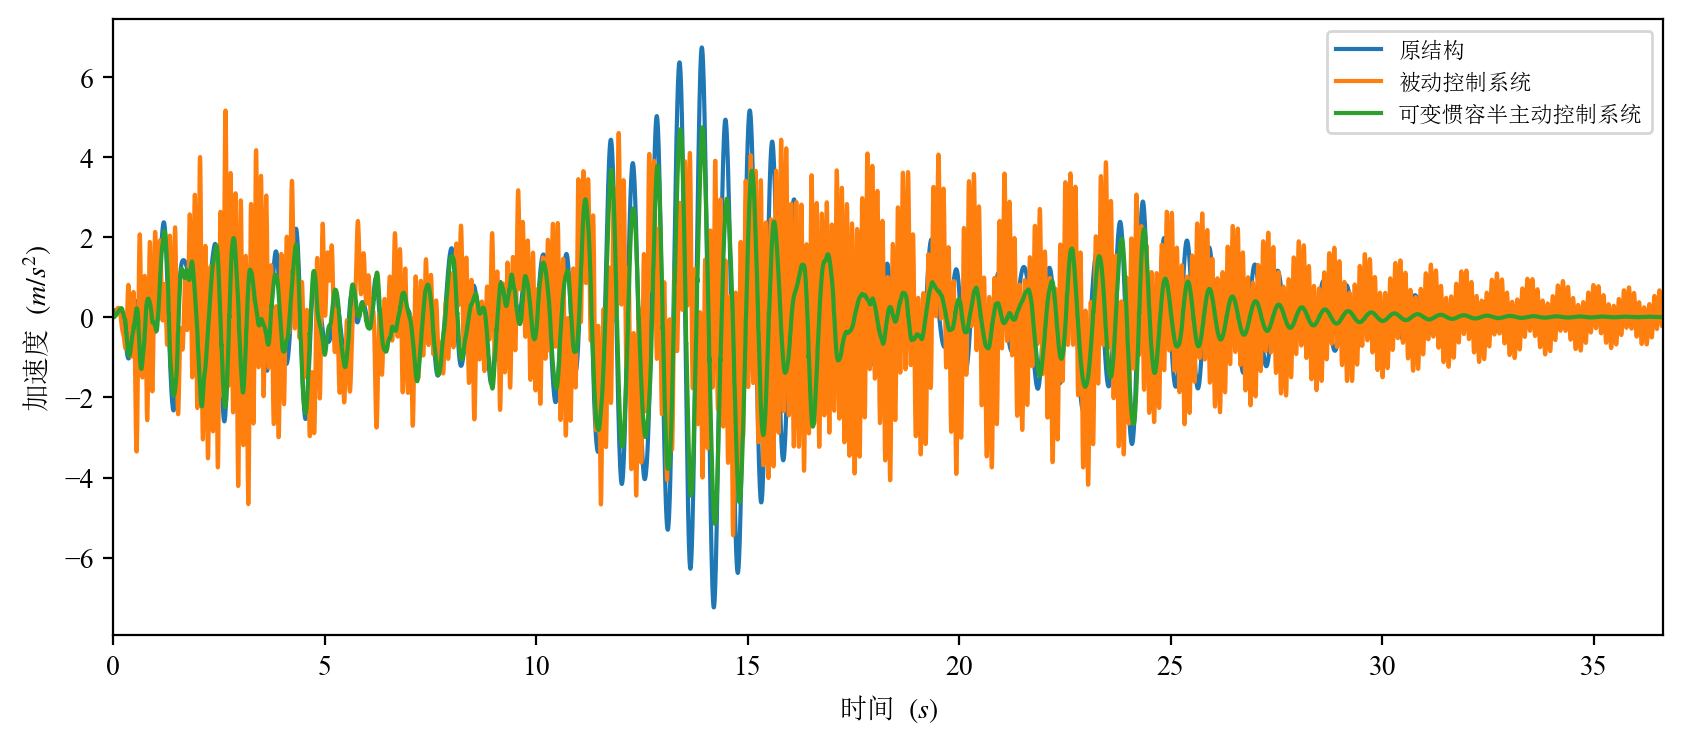

被动控制加速度减震比：0.7512647055067507
半主动控制加速度减震比：0.7121096325839383


In [231]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddy0_ab.reshape(-1), label="原结构")
plt.plot(t_s, ddu1_ab[0, :], label="被动控制系统")
plt.plot(t_s, ddy2_ab, label="可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s^2)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"加速度对比_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制加速度减震比：{}".format(max(abs(ddu1_ab[0, :])) / max(abs(ddy0_ab.reshape(-1)))))
print("半主动控制加速度减震比：{}".format(max(abs(ddy2_ab)) / max(abs(ddy0_ab.reshape(-1)))))

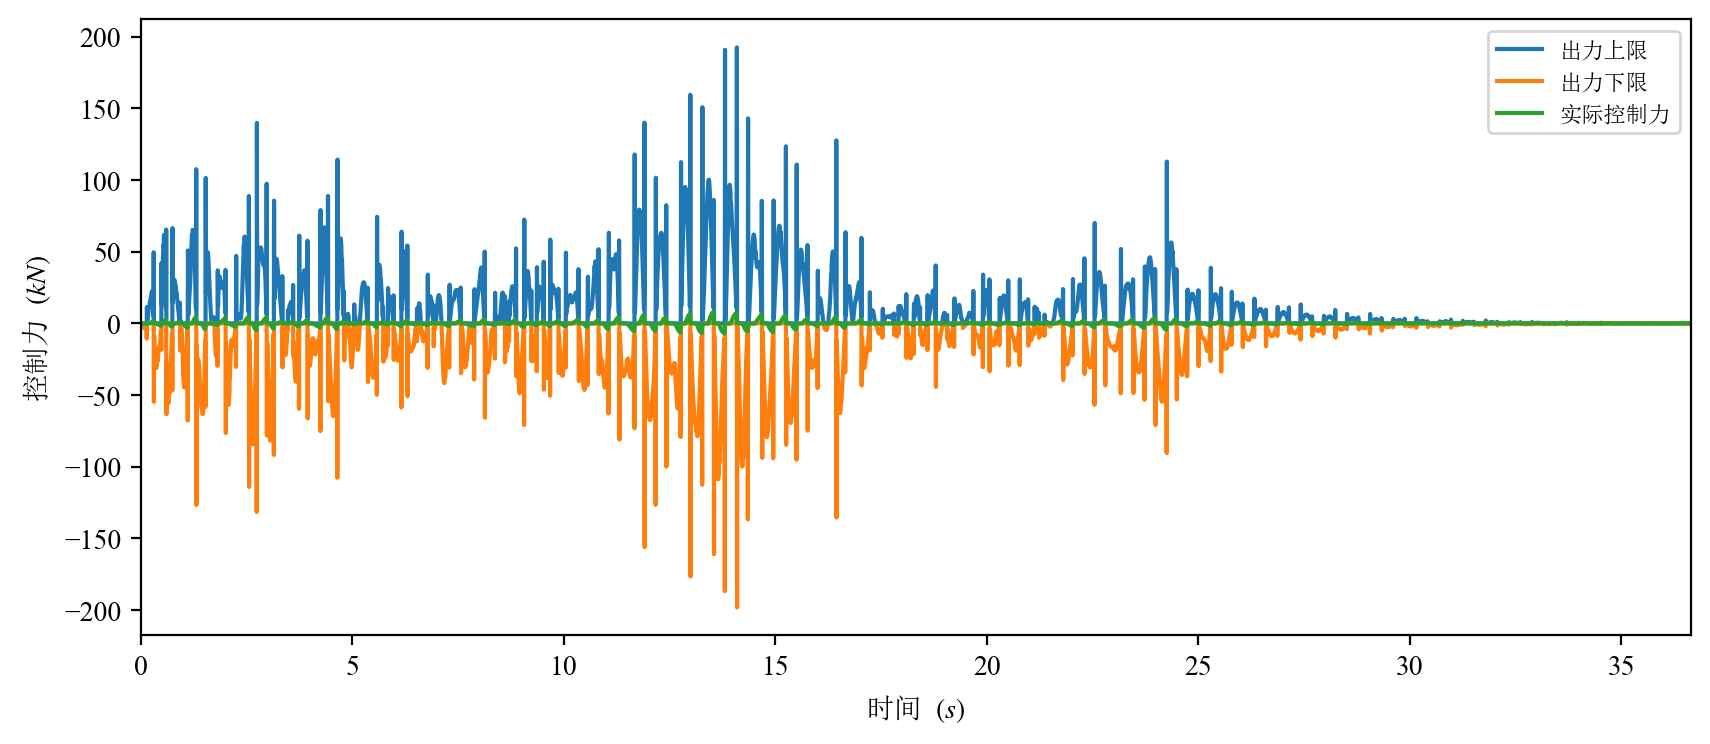

In [232]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, fmax, label="出力上限")
plt.plot(t_s, fmin, label="出力下限")
plt.plot(t_s, fa, label="实际控制力")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'控制力 $(kN)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"控制力限值_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

In [233]:
# 半主动控制结构
u2_ml = np.zeros([2, wave_len_s])
du2_ml = np.zeros([2, wave_len_s])
du2_ml[1, 0] = -wave_s[0]
F = np.zeros([2, wave_len_s])
ft_ml = np.zeros(wave_len_s)
ud_ml = np.zeros(wave_len_s)
dud_ml = np.zeros(wave_len_s)
ddud_ml = np.zeros(wave_len_s)
fmax_ml = np.zeros(wave_len_s)
fmin_ml = np.zeros(wave_len_s)
fa_ml = np.zeros(wave_len_s)
ud_ml_pre = 0
dud_ml_pre = 0

str_pre_disp = 0
str_pre_vel = 0
str_pre_acc = 0
str_cur_disp = 0
str_cur_vel = 0
str_cur_acc = 0
ft_ml_pre = 0
ft_ml_next = 0

y2_ml = np.zeros(wave_len_s)
dy2_ml = np.zeros(wave_len_s)
ddy2_ml = np.zeros(wave_len_s)
ddy2_ab_ml = np.zeros(wave_len_s)
ag_pre = 0
for i in range(wave_len_s - 1):
    str_cur_disp = y2_ml[i - 1]
    str_cur_vel = dy2_ml[i - 1]
    str_cur_acc = ddy2_ab_ml[i - 1]
    ft_ml_cur = ft_ml[i - 1]
    x = np.array([str_cur_disp, str_cur_vel, str_cur_acc, str_pre_disp, str_pre_vel, str_pre_acc, ft_ml_pre, ft_ml_cur], ndmin=2)
    x = ss.transform(x)
    ft_ml[i] = GBoost.predict(x)[0]
    ft_ml_pre = ft_ml_cur
    str_pre_disp = str_cur_disp
    str_pre_vel = str_cur_vel
    str_pre_acc = str_cur_acc

    ud_ml[i] = u2_ml[0, i] - ft_ml[i] / kd  # 当前惯容位移
    dud_ml[i] = (ud_ml[i] - ud_ml[i - 1]) / dt_s  # 当前惯容速度
    ddud_ml[i] = (dud_ml[i] - dud_ml[i - 1]) / dt_s  # 当前惯容加速度

    # 当前出力上限
    fmax_ml[i] = max(
        [min_max * ddud_ml[i] + cd_max * dud_ml[i],
         min_min * ddud_ml[i] + cd_min * dud_ml[i]])
    # 当前出力下限
    fmin_ml[i] = min([min_max * ddud_ml[i] + cd_max * dud_ml[i],
                   min_min * ddud_ml[i] + cd_min * dud_ml[i]])
    while True:
        if ft_ml[i] < fmin_ml[i]:
            ft_ml[i] = fmin_ml[i]
        elif ft_ml[i] > fmax_ml[i]:
            ft_ml[i] = fmax_ml[i]
        else:
            fa_ml[i] = ft_ml[i]
            break
        ud_ml[i] = u2_ml[0, i] - ft_ml[i] / kd  # 当前惯容位移
        dud_ml[i] = (ud_ml[i] - ud_ml[i - 1]) / dt_s  # 当前惯容速度
        ddud_ml[i] = (dud_ml[i] - dud_ml[i - 1]) / dt_s  # 当前惯容加速度

        # 当前出力上限
        fmax_ml[i] = max(
            [min_max * ddud_ml[i] + cd_max * dud_ml[i],
             min_min * ddud_ml[i] + cd_min * dud_ml[i]])
        # 当前出力下限
        fmin_ml[i] = min([min_max * ddud_ml[i] + cd_max * dud_ml[i],
                       min_min * ddud_ml[i] + cd_min * dud_ml[i]])

    # ud_ml_pre = ud_ml[i]
    # dud_ml_pre = dud_ml[i]
    # Newmark_beta法
    ag = wave_s[i] + fa_ml[i] / m
    z_acc = ag - ag_pre
    z_y = (-m * z_acc + (4 / dt) * m * dy2_ml[i] + 2 * m * ddy2_ml[i] + 2 * c * dy2_ml[i]) / (k + 2 * c / dt + m * 4 / (dt ** 2))
    y2_ml[i + 1] = y2_ml[i] + z_y
    z_dy = 2 / dt * z_y - 2 * dy2_ml[i]
    dy2_ml[i + 1] = dy2_ml[i] + z_dy
    z_ddy = 4 / (dt ** 2) * z_y - (4 / dt) * dy2_ml[i] - 2 * ddy2_ml[i]
    ddy2_ml[i + 1] = ddy2_ml[i] + z_ddy
    ddy2_ab_ml[i] = ddy2_ml[i] + ag

    ag_pre = ag
    u2_ml[0, i + 1] = y2_ml[i + 1]
    u2_ml[1, i + 1] = dy2_ml[i + 1]
    du2_ml[0, i] = dy2_ml[i]
    du2_ml[1, i] = ddy2_ab_ml[i]

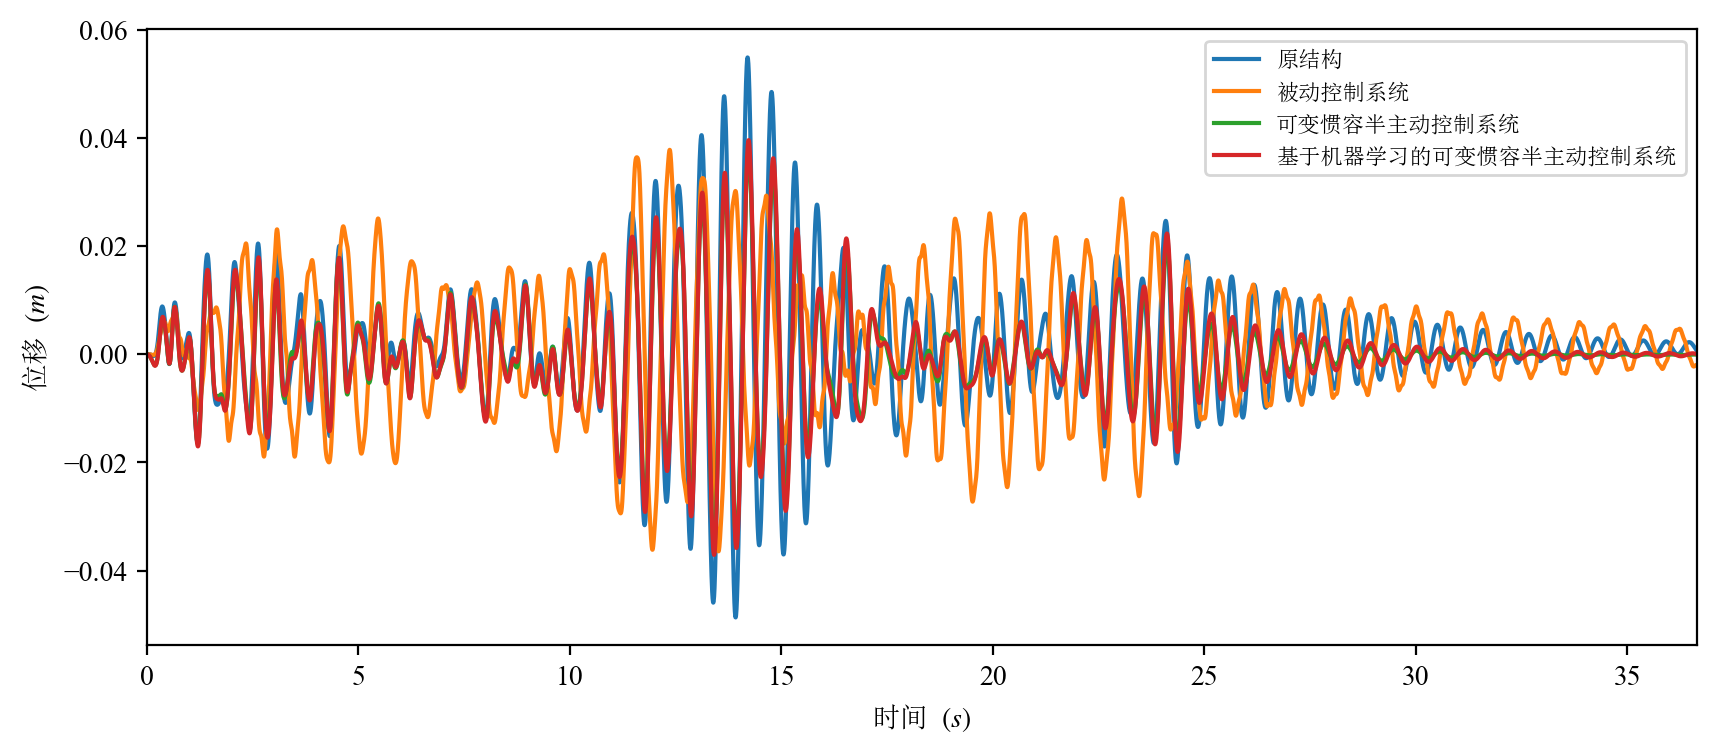

被动控制位移减震比：0.6887977163970579
半主动控制位移减震比：0.6888799604472683
机器学习半主动控制位移减震比：0.7213123358594723


In [234]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, y0.reshape(-1), label="原结构")
plt.plot(t_s, u1[0, :], label="被动控制系统")
plt.plot(t_s, y2, label="可变惯容半主动控制系统")
plt.plot(t_s, y2_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"位移对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制位移减震比：{}".format(max(abs(u1[0, :])) / max(abs(y0.reshape(-1)))))
print("半主动控制位移减震比：{}".format(max(abs(y2)) / max(abs(y0.reshape(-1)))))
print("机器学习半主动控制位移减震比：{}".format(max(abs(y2_ml)) / max(abs(y0.reshape(-1)))))

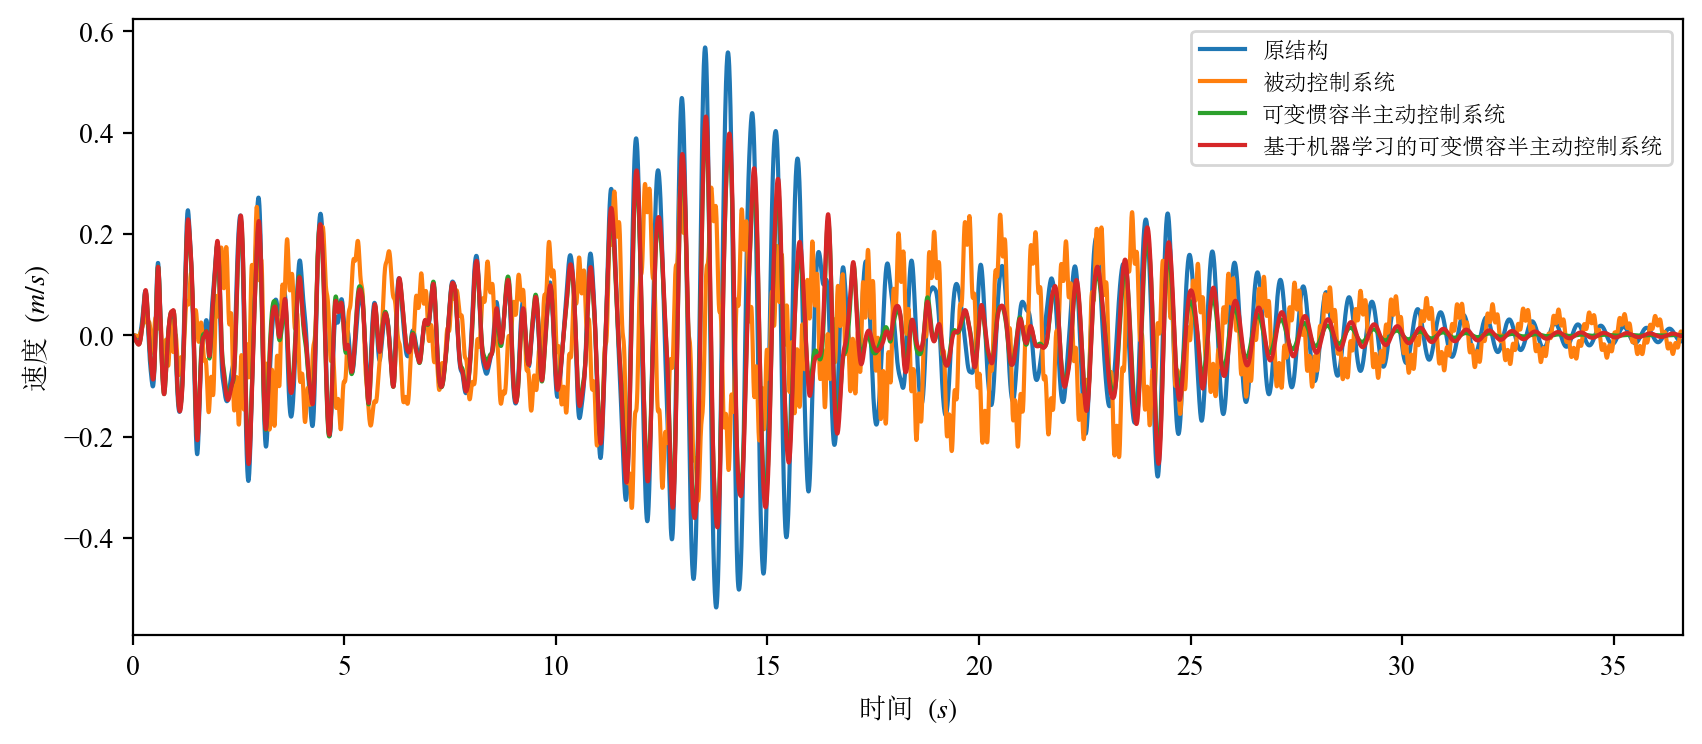

被动控制速度减震比：0.599873885597527
半主动控制速度减震比：0.7286970871232796
机器学习半主动速度位移减震比：0.759783476872512


In [235]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dy0.reshape(-1), label="原结构")
plt.plot(t_s, du1[0, :], label="被动控制系统")
plt.plot(t_s, dy2, label="可变惯容半主动控制系统")
plt.plot(t_s, dy2_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"速度对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制速度减震比：{}".format(max(abs(du1[0, :])) / max(abs(dy0.reshape(-1)))))
print("半主动控制速度减震比：{}".format(max(abs(dy2)) / max(abs(dy0.reshape(-1)))))
print("机器学习半主动速度位移减震比：{}".format(max(abs(dy2_ml)) / max(abs(dy0.reshape(-1)))))

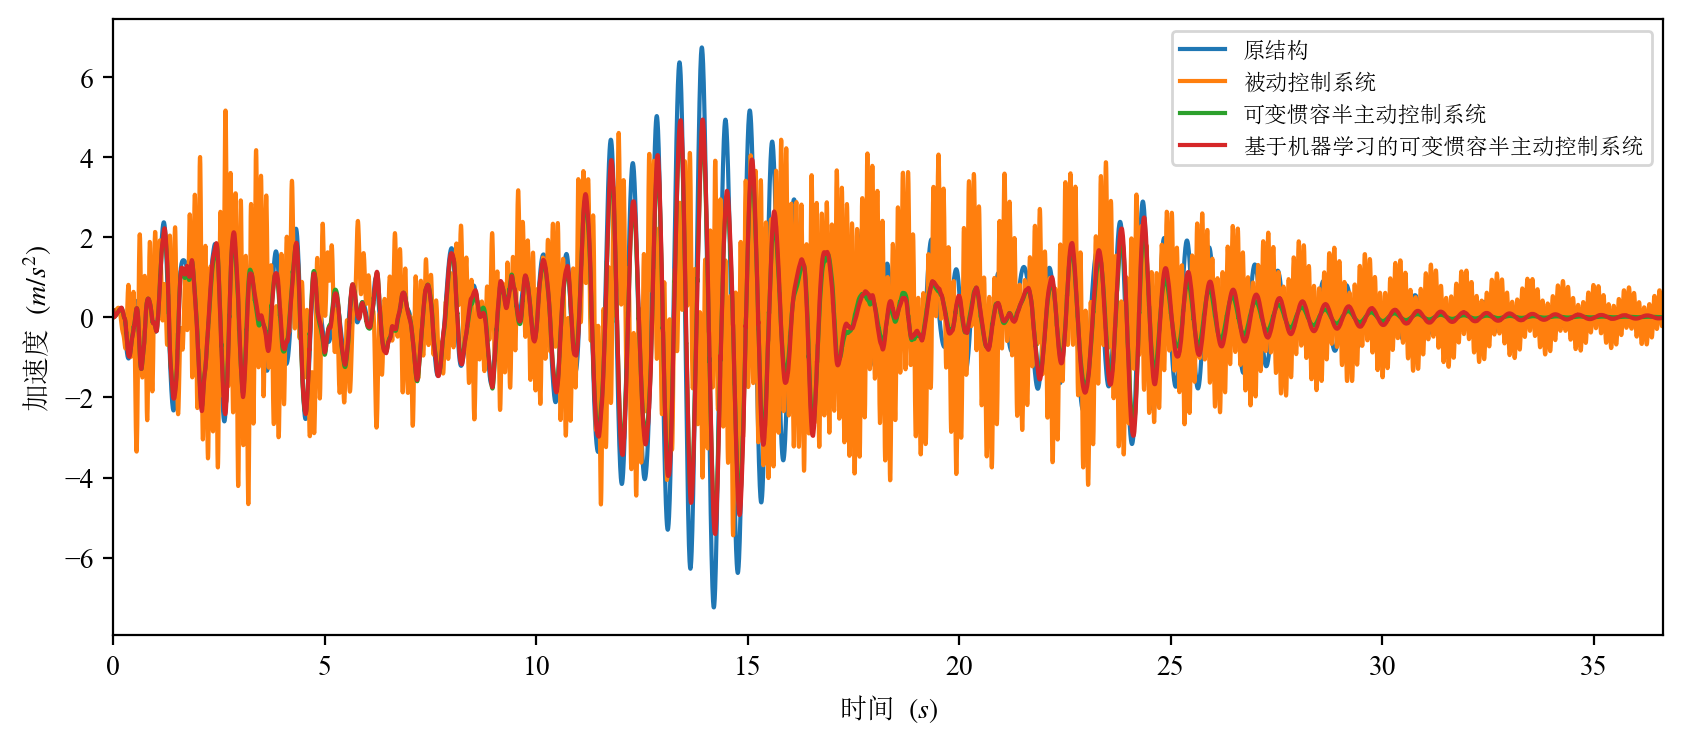

被动控制加速度减震比：0.7512647055067507
半主动控制加速度减震比：0.7121096325839383
机器学习半主动加速度位移减震比：0.7468949872664794


In [236]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddy0_ab.reshape(-1), label="原结构")
plt.plot(t_s, ddu1_ab[0, :], label="被动控制系统")
plt.plot(t_s, ddy2_ab, label="可变惯容半主动控制系统")
plt.plot(t_s, ddy2_ab_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlim([0, max(t_s)])
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s^2)$',fontname = 'SimSun',fontsize = 10)
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"加速度对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()
print("被动控制加速度减震比：{}".format(max(abs(ddu1_ab[0, :])) / max(abs(ddy0_ab.reshape(-1)))))
print("半主动控制加速度减震比：{}".format(max(abs(ddy2_ab)) / max(abs(ddy0_ab.reshape(-1)))))
print("机器学习半主动加速度位移减震比：{}".format(max(abs(ddy2_ab_ml)) / max(abs(ddy0_ab.reshape(-1)))))

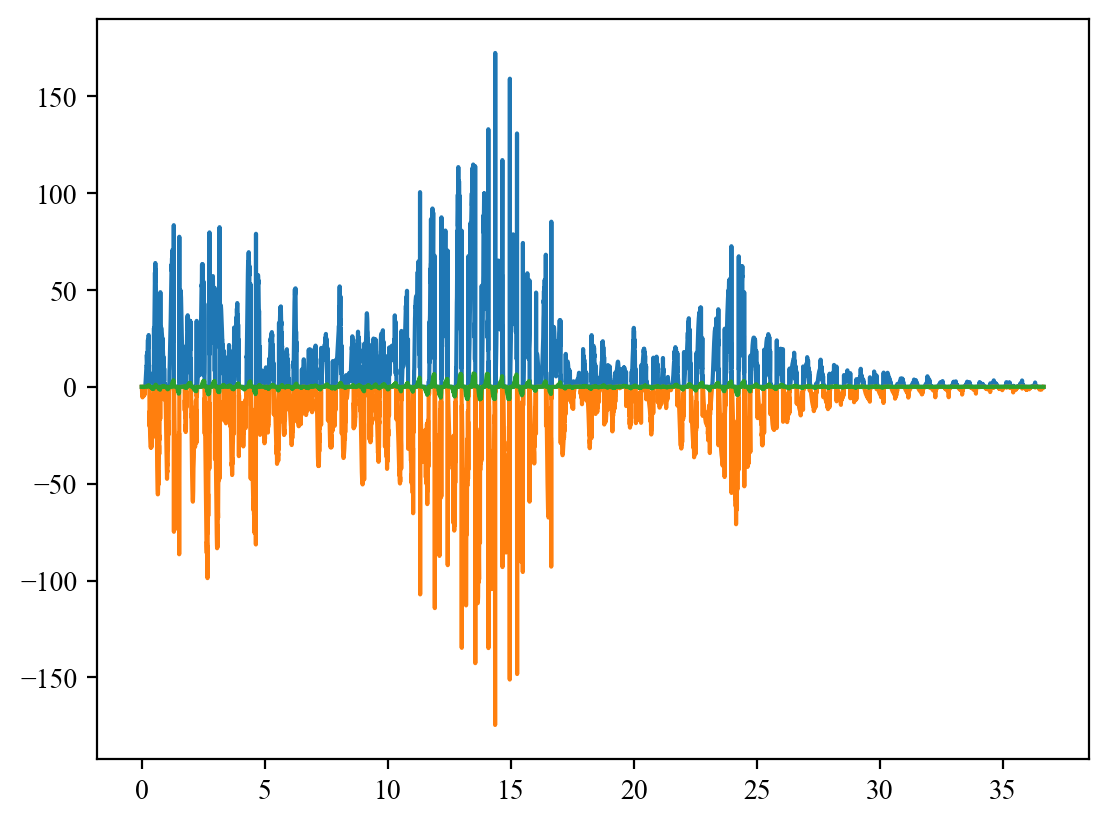

In [237]:
plt.plot(t_s, fmax_ml)
plt.plot(t_s, fmin_ml)
plt.plot(t_s, fa_ml)

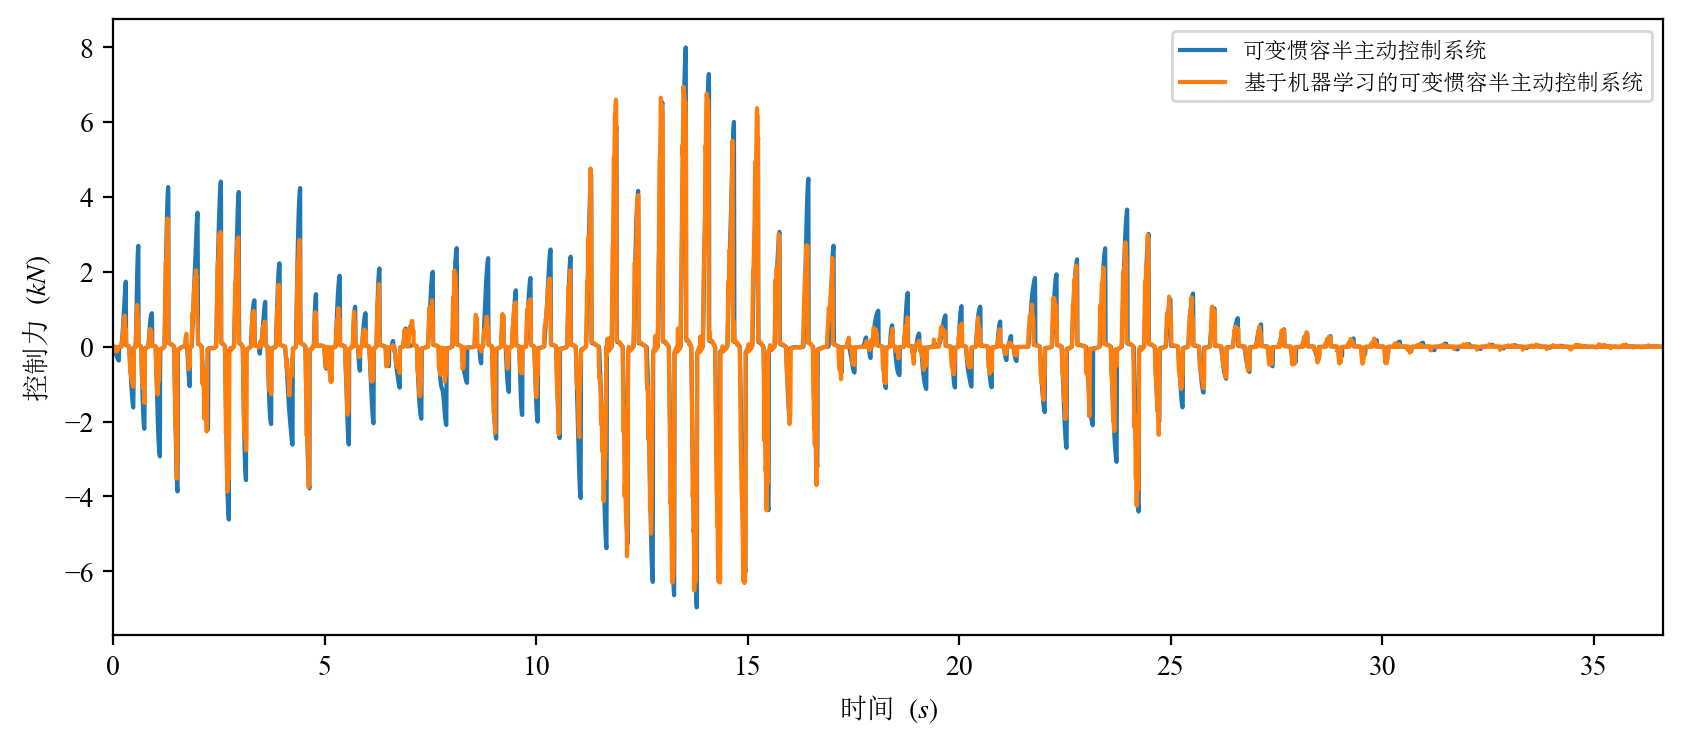

In [238]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, fa, label="可变惯容半主动控制系统")
plt.plot(t_s, fa_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'控制力 $(kN)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"控制力对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

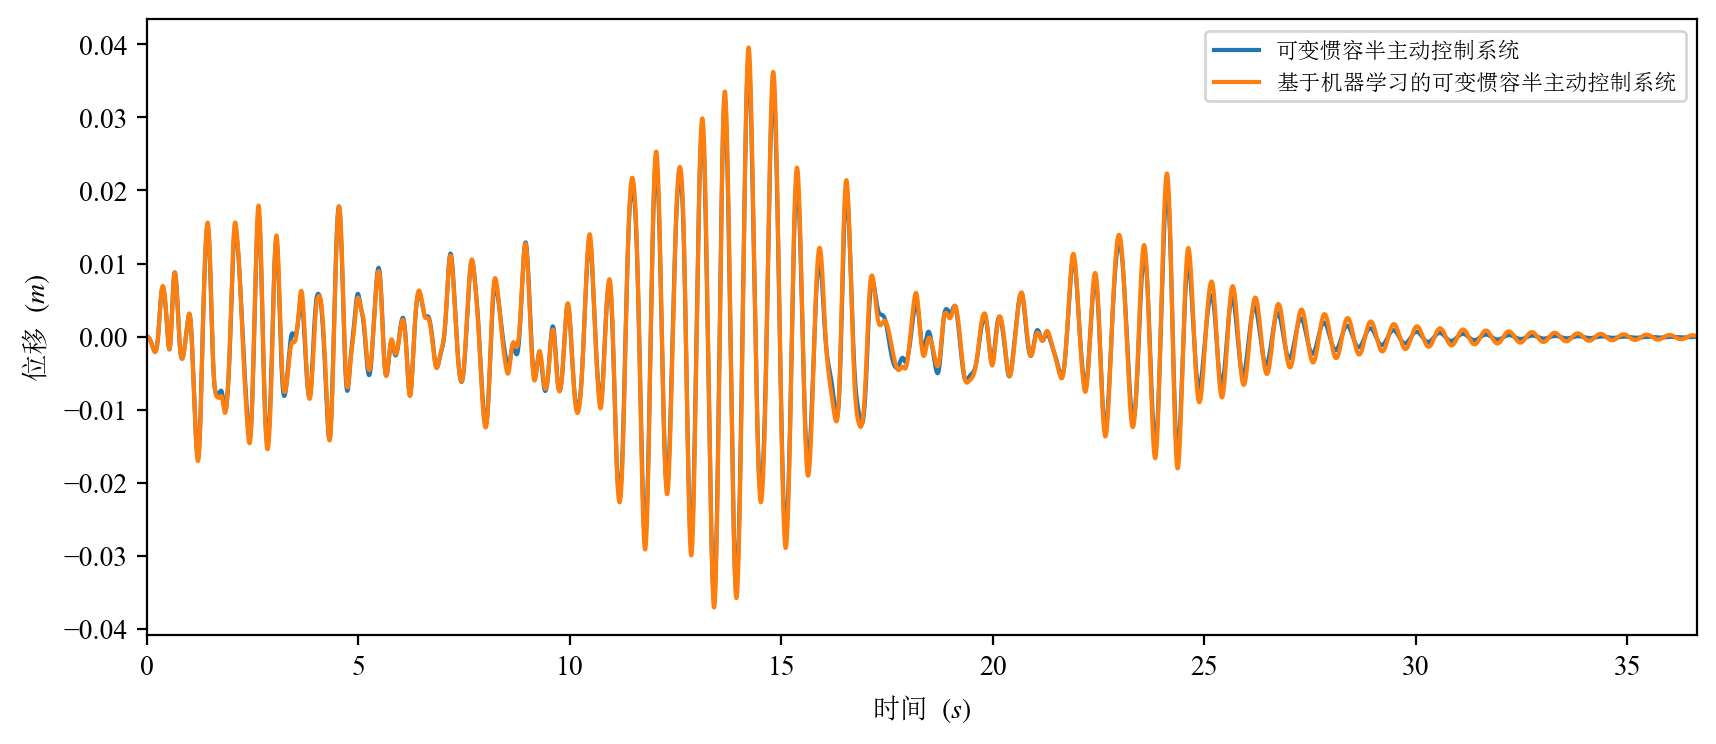

In [239]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ud, label="可变惯容半主动控制系统")
plt.plot(t_s, ud_ml, label="基于机器学习的可变惯容半主动控制系统")

plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'位移 $(m)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件位移对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

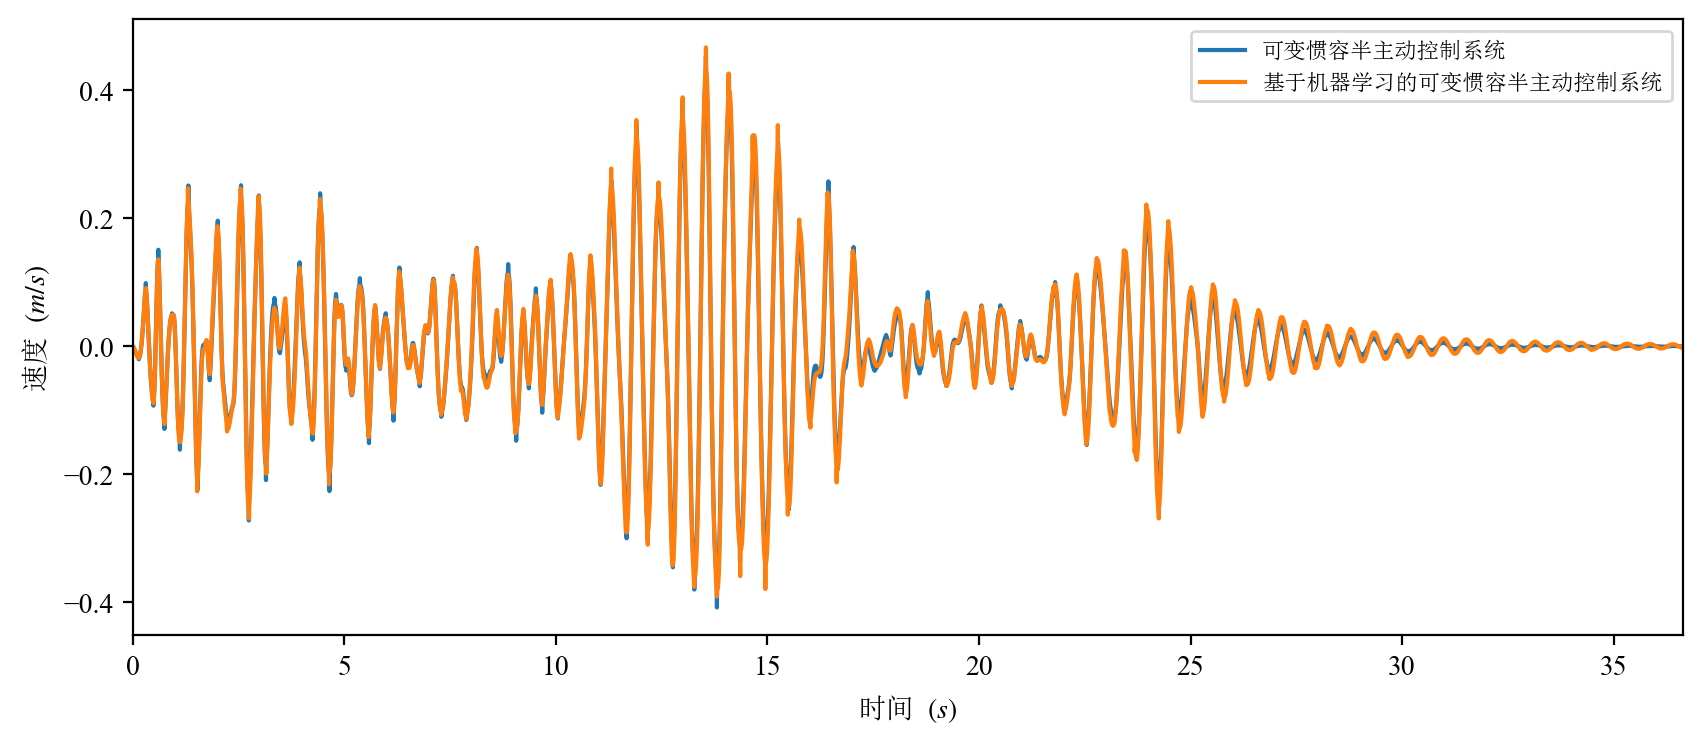

In [240]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, dud, label="可变惯容半主动控制系统")
plt.plot(t_s, dud_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件速度对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()

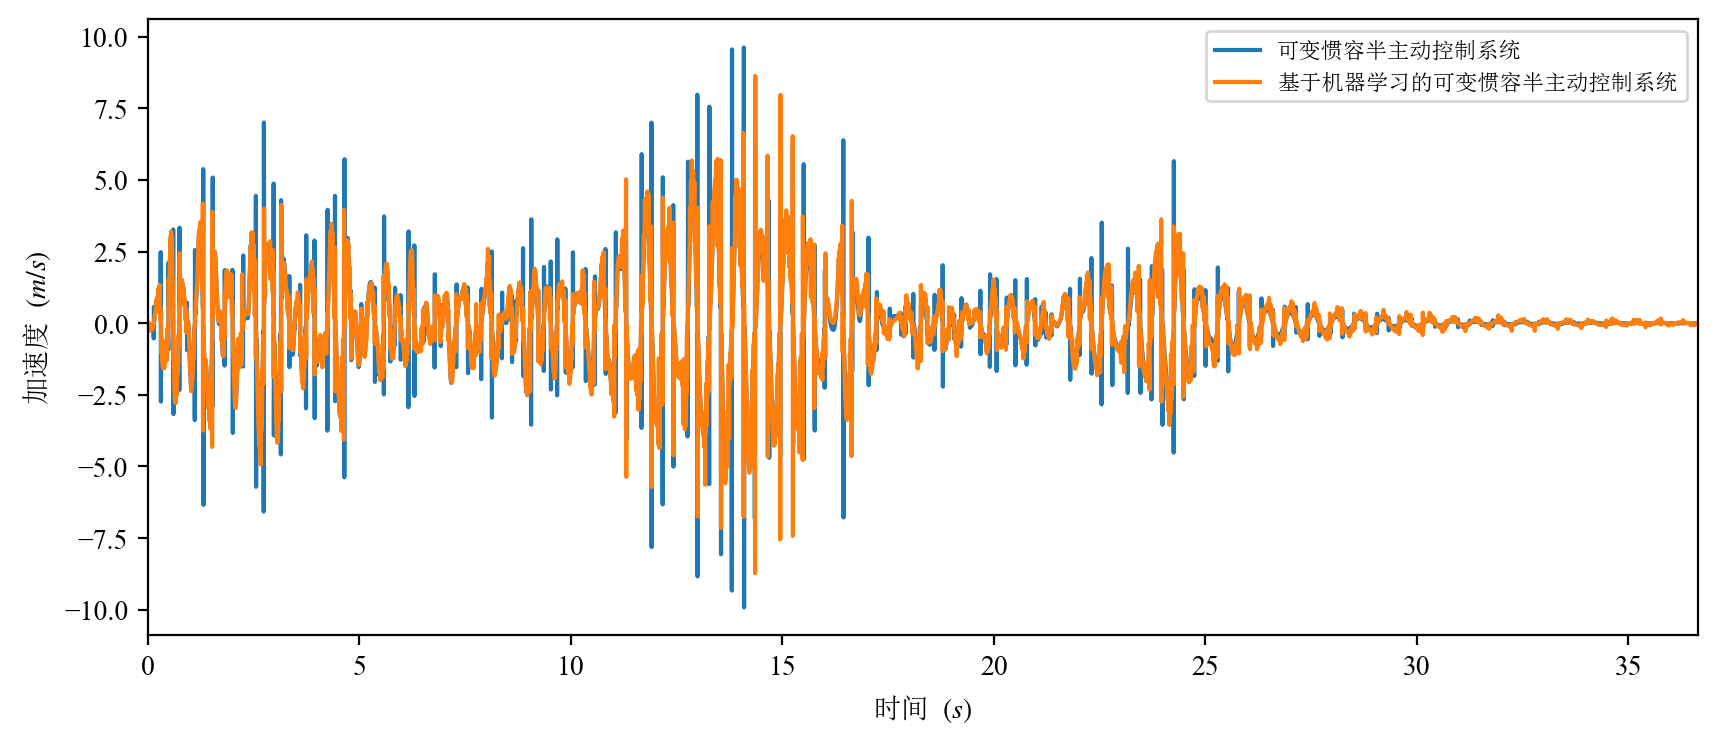

In [241]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(t_s, ddud, label="可变惯容半主动控制系统")
plt.plot(t_s, ddud_ml, label="基于机器学习的可变惯容半主动控制系统")
plt.xlabel(r'时间 $(s)$',fontname = 'SimSun',fontsize = 10)
plt.ylabel(r'加速度 $(m/s)$',fontname = 'SimSun',fontsize = 10)
plt.xlim([0, max(t_s)])
font = {
    "family": "SimSun",
    'weight':'normal',
    "size": 8
    }
plt.legend(prop = font, loc='best')
pic_name = r"惯容元件加速度对比_ml_new"
plt.savefig(r'./pic/{}.png'.format(pic_name),dpi=600, bbox_inches='tight')
plt.show()
plt.close()